# Installing libraries

In [ ]:
# !pip install pyspark

# Importing libraries

In [ ]:
import statistics
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import count, col, when, sum, unix_timestamp, isnan, isnull, max, min, expr, countDistinct
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from google.colab import auth
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.sql import DataFrame as SparkDataFrame
from pyspark.sql.functions import col, lit, expr
from pyspark.sql.functions import first
from pyspark.ml.feature import NGram
from pyspark.sql.functions import col, lit
from pyspark.sql.window import Window
from pyspark.sql.functions import percentile_approx
from pyspark.sql.functions import broadcast
from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import col, datediff, lit
from wordcloud import WordCloud
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import LinearRegression


# Global Variables

In [ ]:
PROJECT_ID = "bdcc24-project2"
DATABASE_NAME = "dataset"
TABLES_NAME = ["admissions", "chartevents", "diagnoses", "icu", "items", "patients","icd_diagnosis","chartevents_filtered"]

# General Functions

In [ ]:
def get_general_information_about_the_table(table):
  print(f"Size:{table.count()}")
  print(pd.DataFrame(table.dtypes, columns = ['Column Name','Data type']))

In [ ]:
def create_pie_graph(title,sizes, labels, plot=True):
  legend_labels = [f"{label}: {size} ({100*size/sizes.sum():.2f})" for label, size in zip(labels, sizes)]

  fig, ax = plt.subplots()
  wedges, texts = ax.pie(sizes, startangle=90, colors=plt.cm.Paired(range(len(sizes))))

  plt.title(title)

  plt.legend(wedges, legend_labels, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

  plt.tight_layout()

  if plot:
    plt.show()
  else:
    return fig, ax

In [ ]:
def get_null_count_per_columns(table):
    from pyspark.sql.functions import count
    colunas = table.columns

    null_counts = {}

    for coluna in colunas:
        null_count = table.select(count(when(isnull(coluna), coluna)).alias('Null_Count')).collect()[0]['Null_Count']
        null_counts[coluna] = null_count

    for coluna, count in null_counts.items():
        print(f"Column {coluna} has {count} null values.")

In [ ]:
def plot_hist_and_boxplot(df, column, spark_table=False):
    if spark_table:
        # Converter para Pandas DataFrame se o input for Spark DataFrame
        pd_df = df.select(column).toPandas()
    else:
        pd_df = df

    plt.figure(figsize=(15, 6))

    # Plotando o histograma
    plt.subplot(1, 2, 1)
    plt.hist(pd_df[column], bins=50, color='blue', alpha=0.7)
    plt.title('Histogram')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True)

    # Plotando o boxplot
    plt.subplot(1, 2, 2)
    plt.boxplot(pd_df[column], vert=True, patch_artist=True)
    plt.title('Boxplot')
    plt.ylabel(column)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
def get_data_with_and_without_outliers(df, column):
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  outliers_data = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

  filtered_data = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

  return filtered_data, outliers_data



In [ ]:
def get_data_with_and_without_top_outliers(df, column, spark_table=False):
    if spark_table:
        # Cálculos para PySpark DataFrame
        stats = df.select(
            expr(f"percentile_approx({column}, 0.25)").alias('Q1'),
            expr(f"percentile_approx({column}, 0.75)").alias('Q3')
        ).collect()

        Q1 = stats[0]['Q1']
        Q3 = stats[0]['Q3']
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers_data = df.filter(col(column) > upper_bound)
        filtered_data = df.filter(col(column) <= upper_bound)
    else:
        # Cálculos para Pandas DataFrame
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers_data = df[df[column] > upper_bound]
        filtered_data = df[df[column] <= upper_bound]

    return filtered_data, outliers_data


In [ ]:
def calculate_bounds(df, column, precisao=0):
    # Calculando o primeiro e terceiro quartis
    quartiles = df.stat.approxQuantile(column, [0.25, 0.75], precisao)
    Q1, Q3 = quartiles[0], quartiles[1]
    IQR = Q3 - Q1

    # Definindo os limites para outliers
    upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR

    return lower_bound, upper_bound

# Google Cloud Authenticate

In [ ]:
auth.authenticate_user()
!gcloud config set project {PROJECT_ID}

Updated property [core/project].


# Spark Initialization

In [ ]:
# Inicialize a sessão do Spark com o pacote do BigQuery especificado
spark = SparkSession.builder \
    .appName("BDCC24") \
    .config('spark.jars.packages', 'com.google.cloud.spark:spark-bigquery-with-dependencies_2.12:0.15.1-beta') \
    .config("spark.executor.memory", "10g") \
    .getOrCreate()

spark.conf.set("google.cloud.auth.service.account.enable", "true")
spark.conf.set("google.cloud.auth.service.account.json.keyfile", "service_account.json")



# Tables Initialization

In [ ]:
tables_loaded = {}
for table in TABLES_NAME:
  print(f"Loading Table {table}")
  tables_loaded[table] = spark.read.format('bigquery')\
                            .option('credentialsFile', "service_account.json")\
                            .option('parentProject', PROJECT_ID)\
                            .option('project', PROJECT_ID)\
                            .option('dataset', DATABASE_NAME)\
                            .option('table',table)\
                            .load()

Loading Table admissions
Loading Table chartevents
Loading Table diagnoses
Loading Table icu
Loading Table items
Loading Table patients
Loading Table icd_diagnosis
Loading Table chartevents_filtered


# Description of Columns Tables

[Data source](https://mimic.mit.edu/docs/iii/tables/)

- ***Table admissions:***
  - ROW ID
  - HADM ID: Unique value representing single patient to a hospital stay
  - SUBJECT ID: Unique to patient may have duplicates indicating same patient admitted multiple times
  - ADMITIME: Date and time of admittion
  - DISCHTIME: Date and time of discharge
  - DEATHTIME: Only present at certain times in case of a in-hospital death. Except through a typographical error is equal to DISCHTIME
  - ADMISSION TIME: Type of Admission (ELECTIVE, URGENT, NEWBORN or EMERGENCY)
  - ADMISSION LOCATION: Location prior to arrival in hospital
  - DISCHARGE LOCATION
  - PATIENT DEMOGRAPHICS(INSURANCE, RELIGION, MARITAL STATUS, ETHNICITY)
  - EDREGTIME: Time that patient was registered from emergency department
  - EDOUTTIME: Time that patient was discharged from emergency department
  - DIAGNOSIS: Preliminary, free text diagnosis for the patient on hospital admission, final diagnosis found on Icd_Diagnosis table.
  - HOSPITAL EXPIRE FLAG: Indicates whether patient died within given hospitalization (0 - Survival, 1 - Death)
  - HAS CHAREVENTS DATA

- ***Table caregivers:***
  - ROW ID
  - CGID: Unique identifier for each distinct caregiver present in the database.
  - LABEL: Defines the type of caregiver: e.g. RN, MD, PharmD, etc.
  - DESCRIPTION: Provides additional information regarding the caregiver

- ***Table chartevents:***
  - ROW ID, SUBJECT ID, HADM ID
  - ICUSTAYS ID: Unique to a patient ICU stay
  - ITEM ID: Identifier for a single measurement type in database. Each row associated to an ITEM ID value corresponds to an instantation of the same measurement
  - CHART TIME: Records the time at which an observation was made, closest proxy to the time the data was actually measured
  - STORE TIME: REcords the time at which an observation was manually inpout or validated by a member of the clinical staff
  - CGID
  - VALUE: Contains the value measured for the concept in ITEM ID. If numeric same as VALUE NUM
  - VALUE NUM: Numeric value if not numeric then value is NULL
  - VALUEOM: Unit of measurement for value
  - WARNING, ERROR
  - RESULTSSTATUS: Specify the type of measurement (MANUAL OR AUTOMATIC)
  - STOPPED

- ***Table diagnoses:***
  - ROW ID, SUBJECT ID, HADM ID
  - SEQ NUM: Order in which ICD diagnosis relate to patient. Ordered by priority
  - ICD9 CODE: Contains the code that corresponds to the diagnosis assigned

- ***Table icu:***
  - ROW ID, SUBJECT ID, HADM ID, ICUSTAY ID
  - DBSOURCE: Contains the original ICU database the data was sourced from
  - FIRST CAREUNIT & LAST CAREUNIT: First and last icu type in which the patient was cared for.
  - FIRST WARDID & LAST WARDID: First and last ICU unit in which the patient stayed.
  - INTIME: Provides the date and time the patient was transferred into the ICU
  - OUTTIME: Provides the date and time the patient was transferred out of the ICU
  - LOS: Length of stay for the patient for the given ICU stay

- ***Table items:***
  - ROW ID, ITEM ID
  - LABEL & ABBREVIATION: Concept represented by ITEM ID
  - DBSOURCE: Clarifies which database the given ITEM ID was sourced from (carevue, metavision)
  - LINKSTO: Table name which the data links to
  - CATEGORY: Provides information of the type of data the ITEM ID corresponds to (ex. ABG - Arterial blood gas)
  - UNITNAME: unit of measurement used for ITEM ID
  - PARAM TYPE: Describes the type of data which is recorded (a date, a number or a text field)
  - CONCEPT ID

- ***Table patients***
  - ROW ID, SUBJECT ID
  - GENDER
  - DOB: Date of birth
  - DOD: Date of death
  - DOD HOSP: Date of dead as recorded in hospital database
  - DOD SSN: Date of death from the social security database
  - EXPIRE FLAG

- ***Table icd diagnosis:***
  - ICD9 CODE
  - SHORT TITLE
  - LONG TITLE

# Data analysis

## Individual Table Analysis

### Table Admissions

Table contains records of all hospital admissions


In [ ]:
admissions_table = tables_loaded["admissions"]

#### Pre Processing

In [ ]:
get_null_count_per_columns(admissions_table)

Column ROW_ID has 0 null values.
Column SUBJECT_ID has 0 null values.
Column HADM_ID has 0 null values.
Column ADMITTIME has 0 null values.
Column DISCHTIME has 0 null values.
Column DEATHTIME has 53122 null values.
Column ADMISSION_TYPE has 0 null values.
Column ADMISSION_LOCATION has 0 null values.
Column DISCHARGE_LOCATION has 0 null values.
Column INSURANCE has 0 null values.
Column LANGUAGE has 25332 null values.
Column RELIGION has 458 null values.
Column MARITAL_STATUS has 10128 null values.
Column ETHNICITY has 0 null values.
Column EDREGTIME has 28099 null values.
Column EDOUTTIME has 28099 null values.
Column DIAGNOSIS has 25 null values.
Column HOSPITAL_EXPIRE_FLAG has 0 null values.
Column HAS_CHARTEVENTS_DATA has 0 null values.


To help with the analysis, we decided to create a column "IS_DECEASED" that will say whether the patient died or not.

In [ ]:
admissions_table = admissions_table.withColumn('IS_DECEASED', when(col('DEATHTIME').isNull(), 0).otherwise(1))

To help with the analysis, we decided to create a "STAY_DURATION" column that will tell the stay in hours

In [ ]:
admissions_table = admissions_table.withColumn("STAY_DURATION", (unix_timestamp("DISCHTIME") - unix_timestamp("ADMITTIME")) / 3600)


In order to avoid erroneous judgments, we chose not to carry out a demographic: analysis.
- LANGUAGE
- RELIGION
- ETHNICITY

In [ ]:

admissions_table = admissions_table.drop("LANGUAGE", "RELIGION", "ETHNICITY")

#### General

In [ ]:
get_general_information_about_the_table(admissions_table)

Size:58976
             Column Name Data type
0                 ROW_ID    bigint
1             SUBJECT_ID    bigint
2                HADM_ID    bigint
3              ADMITTIME    string
4              DISCHTIME    string
5              DEATHTIME    string
6         ADMISSION_TYPE    string
7     ADMISSION_LOCATION    string
8     DISCHARGE_LOCATION    string
9              INSURANCE    string
10        MARITAL_STATUS    string
11             EDREGTIME    string
12             EDOUTTIME    string
13             DIAGNOSIS    string
14  HOSPITAL_EXPIRE_FLAG    bigint
15  HAS_CHARTEVENTS_DATA    bigint
16           IS_DECEASED       int
17         STAY_DURATION    double


#### Group By: ADMISSION_TYPE

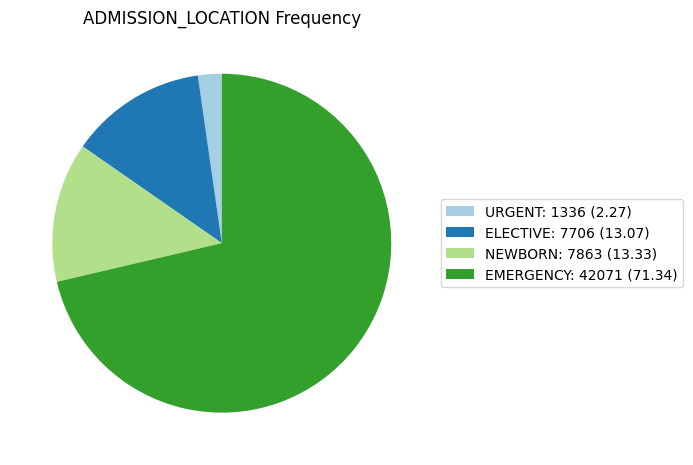

In [ ]:
admissions_types_count = admissions_table.groupBy('ADMISSION_TYPE') \
                      .agg(count('*').alias('total'))\
                      .orderBy("total")

admissions_types_count_df = admissions_types_count.toPandas()
create_pie_graph("ADMISSION_LOCATION Frequency",admissions_types_count_df.total,admissions_types_count_df.ADMISSION_TYPE)

In [ ]:
mortality_by_type = admissions_table.groupBy('ADMISSION_TYPE') \
                      .agg(count('*').alias('total_admissions'),
                           sum('is_deceased').alias('total_deaths')) \
                      .withColumn('mortality_rate', (col('total_deaths') / col('total_admissions')) * 100)\
                      .orderBy("mortality_rate")

mortality_by_type.show()

+--------------+----------------+------------+------------------+
|ADMISSION_TYPE|total_admissions|total_deaths|    mortality_rate|
+--------------+----------------+------------+------------------+
|       NEWBORN|            7863|          62|0.7885031158590868|
|      ELECTIVE|            7706|         197|2.5564495198546586|
|        URGENT|            1336|         161|12.050898203592816|
|     EMERGENCY|           42071|        5434|12.916260607069002|
+--------------+----------------+------------+------------------+



We can see that we have a higher mortality rate for "EMERGENCY", as expected. While for "NEWBORN" we have a low value

In [ ]:
average_stay_by_type = admissions_table.groupBy("ADMISSION_TYPE").agg(
    {"stay_duration": "avg"}
).withColumnRenamed("avg(stay_duration)", "Average Stay Duration (Hours)")\
.orderBy("Average Stay Duration (Hours)")

average_stay_by_type.show()

+--------------+-----------------------------+
|ADMISSION_TYPE|Average Stay Duration (Hours)|
+--------------+-----------------------------+
|      ELECTIVE|           213.19300545029878|
|     EMERGENCY|             240.868200185401|
|       NEWBORN|            276.3727478909652|
|        URGENT|           295.08814870259465|
+--------------+-----------------------------+



#### Group By: ADMISSION_LOCATION

In [ ]:
admissions_location_count = admissions_table.groupBy('ADMISSION_LOCATION') \
                      .agg(count('*').alias('total'))\
                      .orderBy("total")

admissions_location_count_df = admissions_location_count.toPandas()

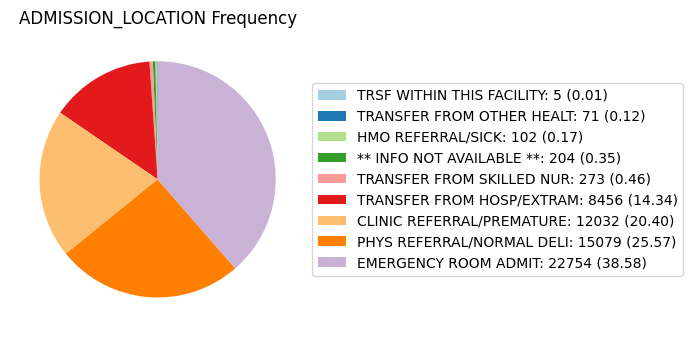

In [ ]:
create_pie_graph("ADMISSION_LOCATION Frequency",admissions_location_count_df.total,admissions_location_count_df.ADMISSION_LOCATION)

In [ ]:
mortality_by_location = admissions_table.groupBy('ADMISSION_LOCATION') \
                      .agg(count('*').alias('total_admissions'),
                           sum('is_deceased').alias('total_deaths')) \
                      .withColumn('mortality_rate', (col('total_deaths') / col('total_admissions')) * 100)\
                      .orderBy("mortality_rate")

mortality_by_location.show()

+--------------------+----------------+------------+------------------+
|  ADMISSION_LOCATION|total_admissions|total_deaths|    mortality_rate|
+--------------------+----------------+------------+------------------+
|TRSF WITHIN THIS ...|               5|           0|               0.0|
|** INFO NOT AVAIL...|             204|           3|1.4705882352941175|
|PHYS REFERRAL/NOR...|           15079|         409| 2.712381457656343|
|   HMO REFERRAL/SICK|             102|           3| 2.941176470588235|
|CLINIC REFERRAL/P...|           12032|        1141| 9.483045212765957|
|TRANSFER FROM HOS...|            8456|        1137|13.446073793755914|
|EMERGENCY ROOM ADMIT|           22754|        3091|13.584424716533357|
|TRANSFER FROM SKI...|             273|          51|18.681318681318682|
|TRANSFER FROM OTH...|              71|          19| 26.76056338028169|
+--------------------+----------------+------------+------------------+



We can see a higher mortality in cases where there was a transition between different healfcare, possibly cases where it was not possible to be treated in one healfcare and had to go to another

One thing that is important to note is that despite this value being high, the amount of admission in this type of admission is not large, being 0.12% of the total. Therefore, taking into account the total number of types, mortality in the emergency room is much higher. In other words, of the 38% of cases, 13.58% die

In [ ]:
average_stay_by_location = admissions_table.groupBy("ADMISSION_LOCATION").agg(
    {"stay_duration": "avg"}
).withColumnRenamed("avg(stay_duration)", "Average Stay Duration (Hours)")\
.orderBy("Average Stay Duration (Hours)")

average_stay_by_location.show()

+--------------------+-----------------------------+
|  ADMISSION_LOCATION|Average Stay Duration (Hours)|
+--------------------+-----------------------------+
|TRSF WITHIN THIS ...|            73.02333333333334|
|   HMO REFERRAL/SICK|           132.74787581699348|
|** INFO NOT AVAIL...|           133.74942810457514|
|PHYS REFERRAL/NOR...|           208.53433362070774|
|EMERGENCY ROOM ADMIT|           235.54906902815623|
|TRANSFER FROM SKI...|            250.3145909645911|
|CLINIC REFERRAL/P...|             274.912275598404|
|TRANSFER FROM HOS...|            282.1644512771998|
|TRANSFER FROM OTH...|            512.1413145539905|
+--------------------+-----------------------------+



We can notice that despite being only 0.12%, the healfcare transfer tends to have a longer duration in the hospital, a higher LOG

#### Group By: SUBJECT_ID

In [ ]:
subject_id_count = admissions_table.groupBy('SUBJECT_ID') \
                      .agg(count('*').alias('total'))\
                      .orderBy("total")

subject_id_count_df = subject_id_count.toPandas()
subject_id_count_df

,SUBJECT_ID,total
0,5556,1
1,15322,1
2,17979,1
3,26543,1
4,29824,1
...,...,...
46515,20643,24
46516,5060,31
46517,11861,34
46518,109,34


In [ ]:
print(f"In a total of {len(subject_id_count_df)} different individuals, most individuals went just {statistics.mode(subject_id_count_df.total)} time to the hospital, where the maximum amount that an individual went to the hospital was {subject_id_count_df.total.max()}")

In a total of 46520 different individuals, most individuals went just 1 time to the hospital, where the maximum amount that an individual went to the hospital was 42


In [ ]:
count_by_subject_id = admissions_table.groupBy("SUBJECT_ID").agg(count("*").alias("Times In The Hospital"))
deaths_by_quantity_subject_id = count_by_subject_id.join(
    admissions_table.filter(col("DEATHTIME").isNotNull()),
    "SUBJECT_ID",
    "inner"
).groupBy("Times In The Hospital").agg(count("*").alias("Deads")).orderBy("Times In The Hospital")
deaths_by_quantity_subject_id.show()

+---------------------+-----+
|Times In The Hospital|Deads|
+---------------------+-----+
|                    1| 4351|
|                    2|  964|
|                    3|  275|
|                    4|  127|
|                    5|   60|
|                    6|   34|
|                    7|   13|
|                    8|    6|
|                    9|   10|
|                   10|    5|
|                   11|    4|
|                   12|    2|
|                   13|    1|
|                   14|    1|
|                   34|    1|
+---------------------+-----+



We can see that the majority of deaths are in patients who only went to the hospital once, we can also see a very "peculiar" case, where an individual went to the hospital 34 times but was unable to resist. We will look back at this specific patient later to see better what happened to him.

#### Group By: DIAGNOSIS    

In [ ]:
diagnosis_count = admissions_table.groupBy('DIAGNOSIS') \
                      .agg(count('*').alias('total'))\
                      .orderBy("total")

diagnosis_count_df = diagnosis_count.toPandas()
diagnosis_count_df

,DIAGNOSIS,total
0,LEFT RADIUS FRACTURE,1
1,PULMONARY EMBOLIS;SUBDURAL HEMATOMA,1
2,BLEEDING GUMS,1
3,LEFT PLEURO EFFUSION,1
4,THIRD DEGREE HEART BLOCK,1
...,...,...
15687,CORONARY ARTERY DISEASE,840
15688,CONGESTIVE HEART FAILURE,928
15689,SEPSIS,1184
15690,PNEUMONIA,1566


In [ ]:
diagnosis_count_df['total'].quantile([0.25, 0.5, 0.75, 0.8, 0.85, 0.9])

0.25    1.0
0.50    1.0
0.75    1.0
0.80    1.0
0.85    2.0
0.90    2.0
Name: total, dtype: float64

We can see that at least 80% of diagnoses have a frequency of 1, that is, this means that the vast majority of diagnoses were recorded only once, suggesting a high diversity of unique diagnoses with few repetitions.

For a more specific analysis, what will happen is the filtering of data where the frequency is equal to 1, leaving only more "rare" cases for a different analysis.


In [ ]:
rare_diagnoses = diagnosis_count.filter(col('total') <= 1)

In [ ]:
f"Total: {rare_diagnoses.count() }"

'Total: 13143'

In [ ]:
admissions_table = admissions_table.join(
    rare_diagnoses,
    on='DIAGNOSIS',
    how='inner'
)

# Visualizar os resultados
admissions_table.count()


13143

#### Group By: MARITAL_STATUS

In [ ]:
marital_status_count = admissions_table.groupBy('MARITAL_STATUS') \
                      .agg(count('*').alias('total'))\
                      .orderBy("total")

marital_status_count_df =  marital_status_count.toPandas()

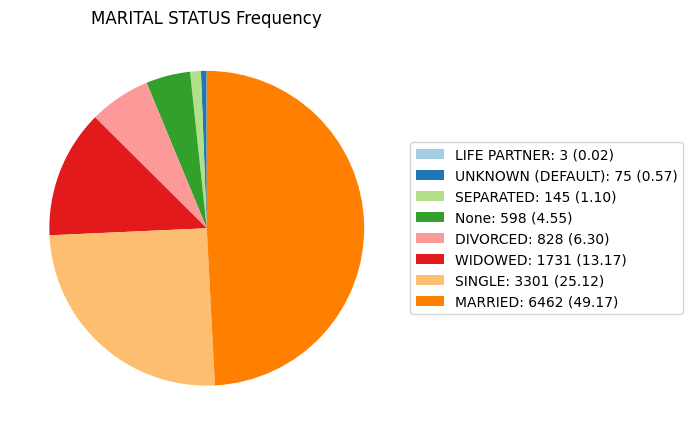

In [ ]:
create_pie_graph("MARITAL STATUS Frequency",marital_status_count_df.total,marital_status_count_df.MARITAL_STATUS)

In [ ]:
mortality_by_marital_status = admissions_table.groupBy('MARITAL_STATUS') \
                      .agg(count('*').alias('total_admissions'),
                           sum('is_deceased').alias('total_deaths')) \
                      .withColumn('mortality_rate', (col('total_deaths') / col('total_admissions')) * 100)\
                      .orderBy("mortality_rate")

mortality_by_marital_status.toPandas()

,MARITAL_STATUS,total_admissions,total_deaths,mortality_rate
0,LIFE PARTNER,3,0,0.000000
1,SEPARATED,145,4,2.758621
2,SINGLE,3301,265,8.027870
3,MARRIED,6462,664,10.275457
4,DIVORCED,828,95,11.473430
5,WIDOWED,1731,264,15.251300
6,UNKNOWN (DEFAULT),75,12,16.000000
7,None,598,131,21.906355


The theory behind the table below was that a person tends to spend less time in hospital if they have a partner. We can see that despite the case of widows, the theory may end up being true

In [ ]:
average_stay_by_marital_status = admissions_table.groupBy("MARITAL_STATUS").agg(
    {"stay_duration": "avg"}
).withColumnRenamed("avg(stay_duration)", "Average Stay Duration (Hours)")\
.orderBy("Average Stay Duration (Hours)")

average_stay_by_marital_status.toPandas()

,MARITAL_STATUS,Average Stay Duration (Hours)
0,LIFE PARTNER,153.544444
1,None,250.379153
2,WIDOWED,251.146823
3,UNKNOWN (DEFAULT),251.951333
4,MARRIED,260.457681
5,SINGLE,263.237226
6,SEPARATED,266.458276
7,DIVORCED,275.081924


#### Group By: INSURANCE

In [ ]:
insurance_count = admissions_table.groupBy('INSURANCE') \
                      .agg(count('*').alias('total'))\
                      .orderBy("total")

insurance_count_df = insurance_count.toPandas()

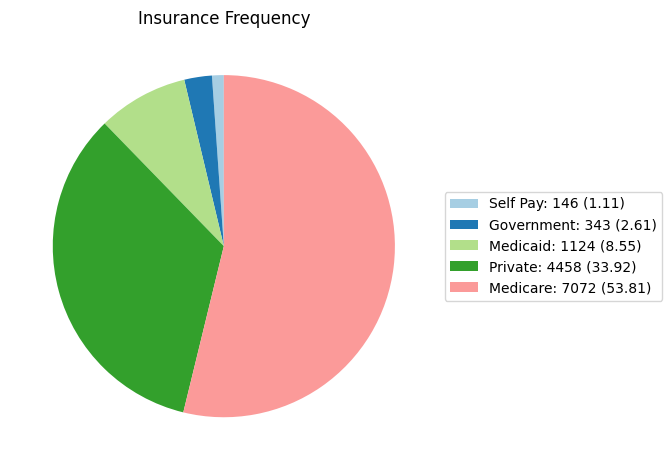

In [ ]:
create_pie_graph("Insurance Frequency",insurance_count_df.total,insurance_count_df.INSURANCE)

In [ ]:
death_by_type_of_insurance = admissions_table.groupBy('INSURANCE') \
                      .agg(count('*').alias('total_admissions'),
                           sum('is_deceased').alias('total_deaths')) \
                      .withColumn('mortality_rate', (col('total_deaths') / col('total_admissions')) * 100)\
                      .orderBy("mortality_rate")

death_by_type_of_insurance.show()

+----------+----------------+------------+------------------+
| INSURANCE|total_admissions|total_deaths|    mortality_rate|
+----------+----------------+------------+------------------+
|  Medicaid|            1124|          84| 7.473309608540925|
|Government|             343|          27| 7.871720116618077|
|   Private|            4458|         377| 8.456707043517273|
|  Medicare|            7072|         923|13.051470588235295|
|  Self Pay|             146|          24| 16.43835616438356|
+----------+----------------+------------+------------------+



We can see people who have Medicare insurance, mortality tends to be higher than that of others

In [ ]:
average_stay_by_insurance = admissions_table.groupBy("INSURANCE").agg(
    {"stay_duration": "avg"}
).withColumnRenamed("avg(stay_duration)", "Average Stay Duration (Hours)")\
.orderBy("Average Stay Duration (Hours)")

average_stay_by_insurance.show()

+----------+-----------------------------+
| INSURANCE|Average Stay Duration (Hours)|
+----------+-----------------------------+
|  Self Pay|           166.89372146118728|
|Government|           233.22614188532543|
|   Private|           254.88408479138653|
|  Medicare|            261.8491044494729|
|  Medicaid|           293.42846975088986|
+----------+-----------------------------+



#### Update Table

In [ ]:
tables_loaded["admissions"] = admissions_table

### Table ICU
Specifically records patients' stays in hospital intensive care units (ICU)

In [ ]:
icu_table = tables_loaded["icu"]

#### Pre Processing

In [ ]:
get_null_count_per_columns(icu_table)

Column ROW_ID has 0 null values.
Column SUBJECT_ID has 0 null values.
Column HADM_ID has 0 null values.
Column ICUSTAY_ID has 0 null values.
Column DBSOURCE has 0 null values.
Column FIRST_CAREUNIT has 0 null values.
Column LAST_CAREUNIT has 0 null values.
Column FIRST_WARDID has 0 null values.
Column LAST_WARDID has 0 null values.
Column INTIME has 0 null values.
Column OUTTIME has 10 null values.
Column LOS has 10 null values.


In [ ]:
los_null = icu_table.where(isnull("LOS"))
los_null.show()

+------+----------+-------+----------+--------+--------------+-------------+------------+-----------+-------------------+-------+----+
|ROW_ID|SUBJECT_ID|HADM_ID|ICUSTAY_ID|DBSOURCE|FIRST_CAREUNIT|LAST_CAREUNIT|FIRST_WARDID|LAST_WARDID|             INTIME|OUTTIME| LOS|
+------+----------+-------+----------+--------+--------------+-------------+------------+-----------+-------------------+-------+----+
| 12871|     10128| 148324|    246075| carevue|          CSRU|         CSRU|          33|         33|2117-03-29 18:58:00|   NULL|NULL|
|   650|       499| 138066|    265303| carevue|          MICU|         MICU|          15|         15|2147-01-18 19:11:00|   NULL|NULL|
| 12923|     10168| 184129|    292281| carevue|          MICU|         MICU|          52|         52|2111-03-06 20:52:00|   NULL|NULL|
|  6628|      5216| 130232|    262702| carevue|          NICU|         NICU|          26|         26|2114-02-26 05:41:00|   NULL|NULL|
| 11108|      8733| 171006|    296619| carevue|        

In [ ]:
icu_table = icu_table.join(los_null, icu_table.ICUSTAY_ID == los_null.ICUSTAY_ID, "left_anti")
get_null_count_per_columns(icu_table)

Column ROW_ID has 0 null values.
Column SUBJECT_ID has 0 null values.
Column HADM_ID has 0 null values.
Column ICUSTAY_ID has 0 null values.
Column DBSOURCE has 0 null values.
Column FIRST_CAREUNIT has 0 null values.
Column LAST_CAREUNIT has 0 null values.
Column FIRST_WARDID has 0 null values.
Column LAST_WARDID has 0 null values.
Column INTIME has 0 null values.
Column OUTTIME has 0 null values.
Column LOS has 0 null values.


Since we are doing an analysis based on the LOS column and since we only have 10 missing data, the strategy followed was to ignore these 10 cases, in order to continue the analysis.

#### Group By: SUBJECT_ID

- The idea is to study to see how many patients returned to the ICU more than once

In [ ]:
subject_id_icu_count = icu_table.groupBy('SUBJECT_ID') \
                      .agg(count('*').alias('total'))\
                      .orderBy("total")

subject_id_icu_count_df = subject_id_count.toPandas()

In [ ]:
print(f"In a total of {len(subject_id_icu_count_df)} different individuals, most individuals went just {statistics.mode(subject_id_icu_count_df.total)} time to the ICU, where the maximum amount that an individual went to the ICU was {subject_id_icu_count_df.total.max()}")

In a total of 46520 different individuals, most individuals went just 1 time to the ICU, where the maximum amount that an individual went to the ICU was 42


In [ ]:
subject_id_icu_count_df['total'].quantile([0.25, 0.5, 0.75, 0.8, 0.85, 0.9])

0.25    1.0
0.50    1.0
0.75    1.0
0.80    1.0
0.85    2.0
0.90    2.0
Name: total, dtype: float64

In the same way as before, what will be done will be a reduction of the data to be analyzed, where we will focus on people who only went to iceu once, as this is part of at least 80% of the data, where the rest will only be data that distorts the data to be analyzed

In [ ]:
once_case_icu = subject_id_icu_count.filter(col('total') <= 1)

In [ ]:
icu_table = icu_table.join(
    once_case_icu,
    on='SUBJECT_ID',
    how='inner'
)

#### Analyze on the "LOS" column

In [ ]:
los_pd = icu_table.select("LOS","ROW_ID").toPandas()

In [ ]:
los_pd["LOS"].describe()

count    37712.000000
mean         5.080468
std         10.780349
min          0.000200
25%          1.034075
50%          1.967450
75%          4.275725
max        171.622700
Name: LOS, dtype: float64

We can see that 50% of people hospitalized stay between 1 day and 4 days, so we can see that it is not so common to stay that long

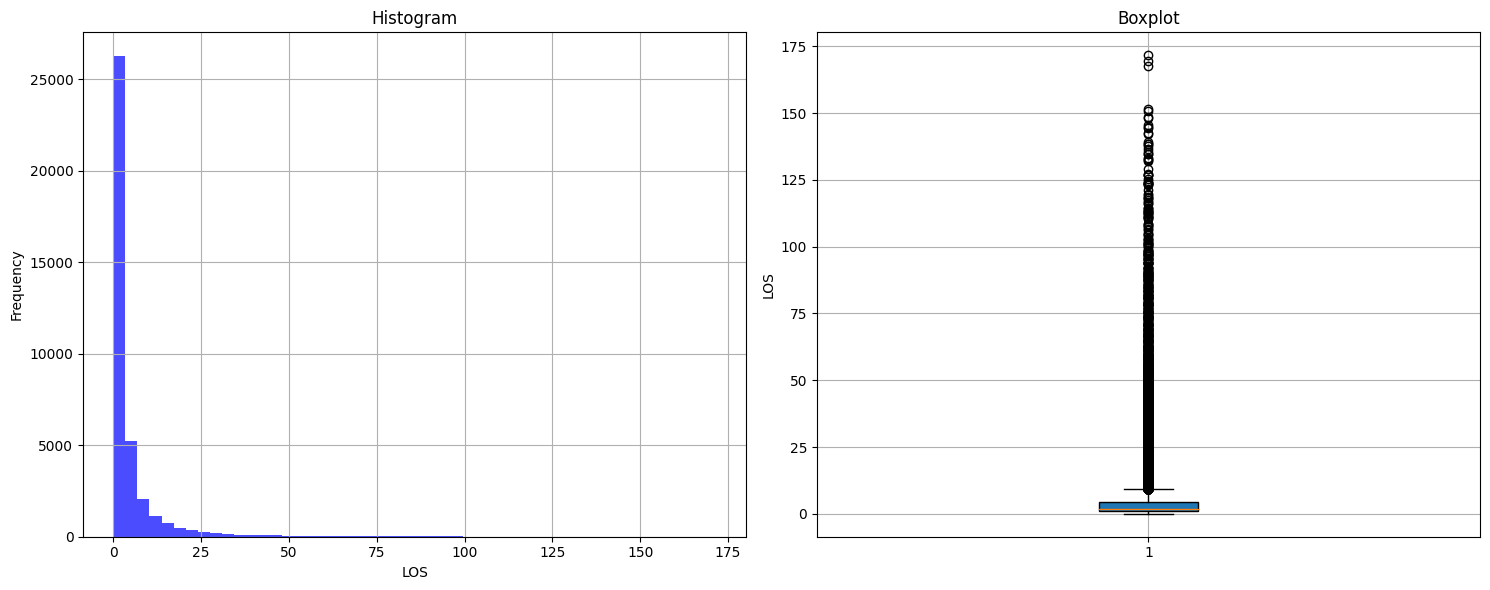

In [ ]:
plot_hist_and_boxplot(los_pd,"LOS")

Confirming what was said previously, we can see both in the boxplot and in the histogram that the majority of ICU stays are relatively short, while there are some very long stays that are exceptional.

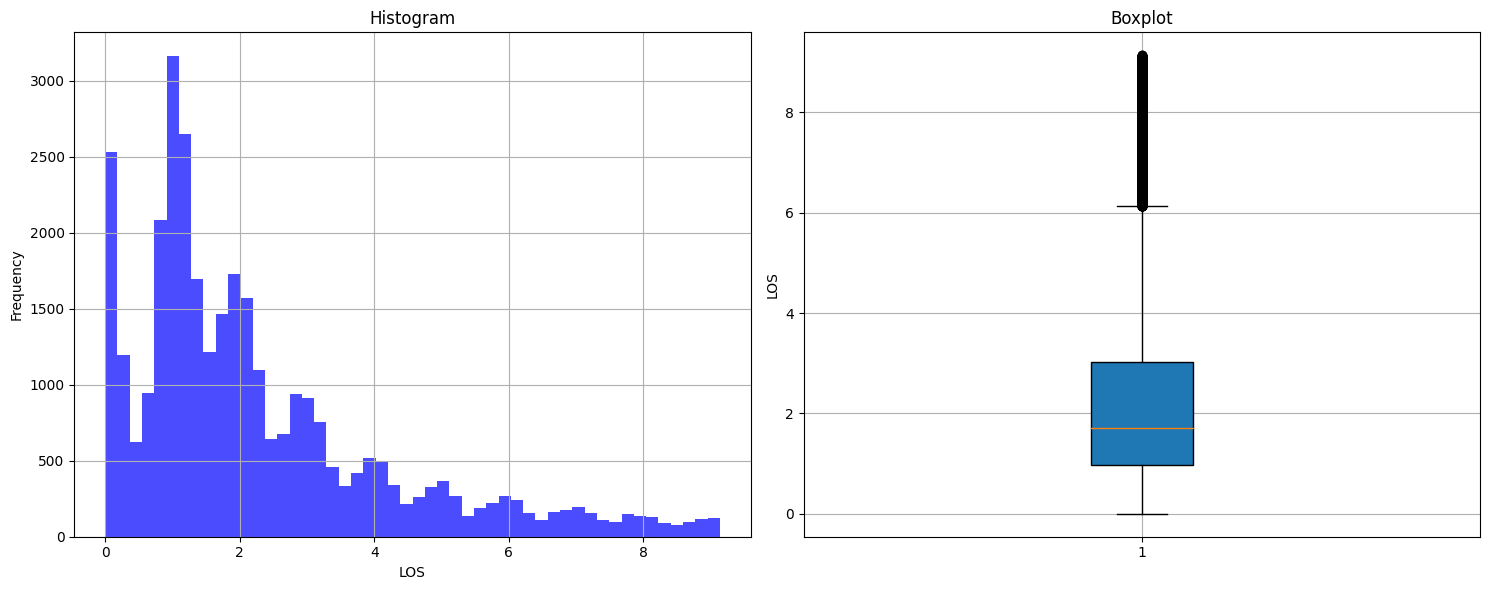

In [ ]:
filtered_data,outliers_data =  get_data_with_and_without_outliers(los_pd,"LOS")
plot_hist_and_boxplot(filtered_data,"LOS")


Once we remove the outliers we can more clearly see the trend of low number of days in the ICU

In [ ]:
outliers_spark = spark.createDataFrame(outliers_data)
icu_table = icu_table.join(outliers_spark, ["ROW_ID"], "left_anti")

#### Analyze FIRST_CAREUNIT vs LAST_CAREUNIT vs LOS


- CCU:	Coronary care unit
- CSRU:	Cardiac surgery recovery unit
- MICU:	Medical intensive care unit
- NICU:	Neonatal intensive care unit
- NWARD:	Neonatal ward
- SICU:	Surgical intensive care unit
- TSICU:	Trauma/surgical intensive care uni

In [ ]:
first_careunit_count = icu_table.groupBy('FIRST_CAREUNIT') \
                      .agg(count('*').alias('total'))\
                      .orderBy("total")

first_careunit_count_df = first_careunit_count.toPandas()

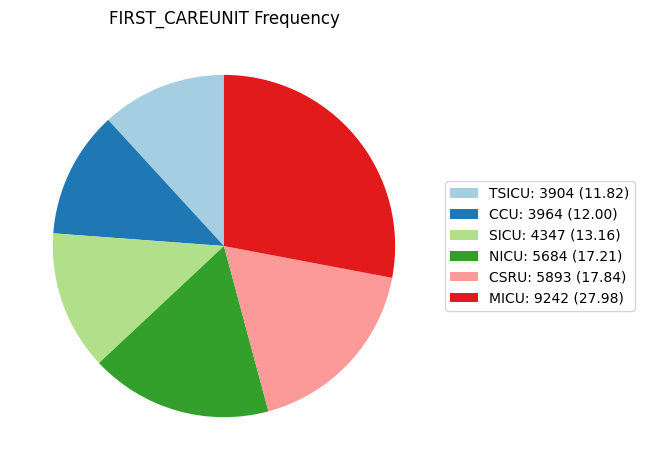

In [ ]:
create_pie_graph("FIRST_CAREUNIT Frequency",first_careunit_count_df.total,first_careunit_count_df.FIRST_CAREUNIT)

In [ ]:
last_careunit_count = icu_table.groupBy('LAST_CAREUNIT') \
                      .agg(count('*').alias('total'))\
                      .orderBy("total")

last_careunit_count_df = last_careunit_count.toPandas()

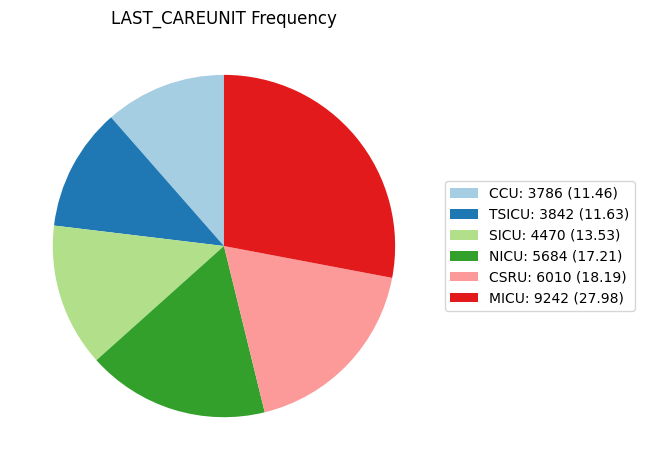

In [ ]:
create_pie_graph("LAST_CAREUNIT Frequency",last_careunit_count_df.total,last_careunit_count_df.LAST_CAREUNIT)

In [ ]:
no_transitions_df = icu_table.filter(col("FIRST_CAREUNIT") == col("LAST_CAREUNIT"))
no_transitions_counts = no_transitions_df.groupBy("FIRST_CAREUNIT", "LAST_CAREUNIT").count().orderBy("count", ascending=False)
no_transitions_counts.show()

+--------------+-------------+-----+
|FIRST_CAREUNIT|LAST_CAREUNIT|count|
+--------------+-------------+-----+
|          MICU|         MICU| 8864|
|          NICU|         NICU| 5684|
|          CSRU|         CSRU| 5674|
|          SICU|         SICU| 4126|
|         TSICU|        TSICU| 3666|
|           CCU|          CCU| 3528|
+--------------+-------------+-----+



In [ ]:
transitions_df = icu_table.filter(col("FIRST_CAREUNIT") != col("LAST_CAREUNIT"))
transition_counts = transitions_df.groupBy("FIRST_CAREUNIT", "LAST_CAREUNIT").count().orderBy("count", ascending=False)
transition_counts.show()

+--------------+-------------+-----+
|FIRST_CAREUNIT|LAST_CAREUNIT|count|
+--------------+-------------+-----+
|           CCU|         CSRU|  274|
|          MICU|         SICU|  170|
|          SICU|         MICU|  125|
|          CSRU|          CCU|  121|
|           CCU|         MICU|  108|
|         TSICU|         SICU|  104|
|         TSICU|         MICU|   99|
|          MICU|          CCU|   88|
|          MICU|        TSICU|   82|
|          SICU|        TSICU|   58|
|          CSRU|         MICU|   46|
|          MICU|         CSRU|   38|
|          CSRU|         SICU|   37|
|           CCU|         SICU|   33|
|         TSICU|          CCU|   25|
|          SICU|          CCU|   24|
|           CCU|        TSICU|   21|
|          CSRU|        TSICU|   15|
|          SICU|         CSRU|   14|
|         TSICU|         CSRU|   10|
+--------------+-------------+-----+



Through the table above we can see the care units that have a greater "migratory" movement, but is this related to the average length of stay? The theory behind the analysis that follows is taking into account that possibly time, LOG, is related to location.

In [ ]:
print("Average time table for careunits with and without transition, for FIRST_CAREUNIT")

no_transitions_los_first_careunit = no_transitions_df.groupBy("FIRST_CAREUNIT").agg(F.mean("LOS").alias("Average_LOS")).orderBy("Average_LOS")
transitions_los_first_careunit = transitions_df.groupBy("FIRST_CAREUNIT").agg(F.mean("LOS").alias("Average_LOS")).orderBy("Average_LOS")

full_los_comparison_first_careunit = no_transitions_los_first_careunit.join(
    transitions_los_first_careunit,
    no_transitions_los_first_careunit.FIRST_CAREUNIT == transitions_los_first_careunit.FIRST_CAREUNIT,
    "full_outer"
).select(
    no_transitions_los_first_careunit.FIRST_CAREUNIT.alias("Care_Unit"),
    no_transitions_los_first_careunit.Average_LOS.alias("Average_LOS_No_Transition"),
    transitions_los_first_careunit.Average_LOS.alias("Average_LOS_Transition")
)
full_los_comparison_first_careunit_diff = full_los_comparison_first_careunit.withColumn(
    "LOS_Difference",
    F.col("Average_LOS_Transition") - F.col("Average_LOS_No_Transition")
).orderBy("LOS_Difference")
full_los_comparison_first_careunit_diff.show()

Average time table for careunits with and without transition, for FIRST_CAREUNIT
+---------+-------------------------+----------------------+------------------+
|Care_Unit|Average_LOS_No_Transition|Average_LOS_Transition|    LOS_Difference|
+---------+-------------------------+----------------------+------------------+
|     NICU|         1.42932429627023|                  NULL|              NULL|
|    TSICU|        2.330672640480093|     3.460247899159666|1.1295752586795733|
|     MICU|       2.4050278768050357|    3.6298388888888886| 1.224811012083853|
|     SICU|          2.4643039263209|    3.7546941176470594|1.2903901913261593|
|     CSRU|       2.3508063976031033|    3.7783009132420093| 1.427494515638906|
|      CCU|        2.312798724489796|     4.196793348623857|1.8839946241340613|
+---------+-------------------------+----------------------+------------------+



In [ ]:
print("Average time table for careunits with and without transition, for LAST_CAREUNIT")

no_transitions_los_last_careunit = no_transitions_df.groupBy("LAST_CAREUNIT").agg(F.mean("LOS").alias("Average_LOS")).orderBy("Average_LOS")
transitions_los_last_careunit = transitions_df.groupBy("LAST_CAREUNIT").agg(F.mean("LOS").alias("Average_LOS")).orderBy("Average_LOS")

full_los_comparison_last_careunit = no_transitions_los_last_careunit.join(
    transitions_los_last_careunit,
    no_transitions_los_last_careunit.LAST_CAREUNIT == transitions_los_last_careunit.LAST_CAREUNIT,
    "full_outer"
).select(
    no_transitions_los_last_careunit.LAST_CAREUNIT.alias("Care_Unit"),
    no_transitions_los_last_careunit.Average_LOS.alias("Average_LOS_No_Transition"),
    transitions_los_last_careunit.Average_LOS.alias("Average_LOS_Transition")
)
full_los_comparison_last_careunit_diff = full_los_comparison_last_careunit.withColumn(
    "LOS_Difference",
    F.col("Average_LOS_Transition") - F.col("Average_LOS_No_Transition")
).orderBy("LOS_Difference")
full_los_comparison_last_careunit_diff.show()

Average time table for careunits with and without transition, for LAST_CAREUNIT
+---------+-------------------------+----------------------+------------------+
|Care_Unit|Average_LOS_No_Transition|Average_LOS_Transition|    LOS_Difference|
+---------+-------------------------+----------------------+------------------+
|     NICU|         1.42932429627023|                  NULL|              NULL|
|     SICU|          2.4643039263209|    3.5021212209302335|1.0378172946093334|
|    TSICU|        2.330672640480093|     3.624504545454546| 1.293831904974453|
|     MICU|       2.4050278768050357|    3.7226198412698395|1.3175919644648038|
|      CCU|        2.312798724489796|    3.9051972868217035|1.5923985623319075|
|     CSRU|       2.3508063976031033|     4.242028571428573|  1.89122217382547|
+---------+-------------------------+----------------------+------------------+



We can see that the LOS tends to increase when a careunit change occurs. Could this be related to the death or the diagnosis? We will see this later in the analysis between tables

#### Update Table

In [ ]:
tables_loaded["icu"] = icu_table

### Table chartevents

Since we originally have more than 300 million pieces of data, what we thought was to do a slightly more restricted analysis. What we did was use bigquery to filter the 10 most frequent ITEMIDs, as well as filter the number of days that observations were made, with a total of 2 days. In other words, we took the first 48 hours of observation, together with the 10 most frequent ITEMIDs

In [ ]:
table_chartevents_filtered = tables_loaded["chartevents_filtered"]

#### Pre Processing

In [ ]:
get_general_information_about_the_table(table_chartevents_filtered)

Size:9527683
     Column Name  Data type
0         ROW_ID     bigint
1     SUBJECT_ID     bigint
2        HADM_ID     bigint
3     ICUSTAY_ID     double
4         ITEMID     bigint
5      CHARTTIME  timestamp
6      STORETIME  timestamp
7           CGID     double
8          VALUE     string
9       VALUENUM     double
10      VALUEUOM     string
11       WARNING     double
12         ERROR     double
13  RESULTSTATUS     string
14       STOPPED     string


In [ ]:
get_null_count_per_columns(table_chartevents_filtered)

Column ROW_ID has 0 null values.
Column SUBJECT_ID has 0 null values.
Column HADM_ID has 0 null values.
Column ICUSTAY_ID has 7639 null values.
Column ITEMID has 0 null values.
Column CHARTTIME has 0 null values.
Column STORETIME has 109158 null values.
Column CGID has 109158 null values.
Column VALUE has 30571 null values.
Column VALUENUM has 4494945 null values.
Column VALUEUOM has 4491819 null values.
Column WARNING has 8742295 null values.
Column ERROR has 8742295 null values.
Column RESULTSTATUS has 9527683 null values.
Column STOPPED has 785394 null values.


We can see that the tables below have a very high number of nulls, so they will be removed to avoid problems in the analysis.
- STOPPED
- RESULTSTATUS
- ERROR
- WARNING

In [ ]:
table_chartevents_filtered = table_chartevents_filtered.drop("STOPPED", "RESULTSTATUS", "ERROR", "WARNING")

Since we will not analyze which caregiver made the note, we will remove it from the table

In [ ]:
table_chartevents_filtered = table_chartevents_filtered.drop("CGID")

In [ ]:
get_general_information_about_the_table(table_chartevents_filtered)


Size:9527683
  Column Name  Data type
0      ROW_ID     bigint
1  SUBJECT_ID     bigint
2     HADM_ID     bigint
3  ICUSTAY_ID     double
4      ITEMID     bigint
5   CHARTTIME  timestamp
6   STORETIME  timestamp
7       VALUE     string
8    VALUENUM     double
9    VALUEUOM     string


#### Group By: SUBJECT_ID

In [ ]:
chartevents_subjects_count = table_chartevents_filtered.groupBy('SUBJECT_ID') \
                      .agg(count('*').alias('total'))\
                      .orderBy("total", ascending=False)

In [ ]:
chartevents_subjects_count.show()

+----------+-----+
|SUBJECT_ID|total|
+----------+-----+
|     80345| 2856|
|     84120| 2837|
|     90776| 2829|
|     58854| 2829|
|     79337| 2827|
|     43459| 2800|
|     83629| 2791|
|     58723| 2736|
|     61106| 2724|
|     92353| 2717|
|     46156| 2695|
|     48380| 2694|
|     48935| 2664|
|     54073| 2662|
|     40187| 2660|
|     86965| 2605|
|     57390| 2594|
|     41861| 2579|
|     45910| 2551|
|     55205| 2539|
+----------+-----+
only showing top 20 rows



#### Analyze on VALUENUM && VALUEUOM && VALUE

In [ ]:
categorical_values = table_chartevents_filtered.filter(
    (col("VALUENUM").isNull()) & (col("VALUE").isNotNull())
).groupBy("VALUE").count().orderBy("count", ascending=False)

categorical_values.show(10)

+------------+------+
|       VALUE| count|
+------------+------+
|   Full Code|815611|
|        None|814749|
|   Universal|803517|
|Normal Sinus|590412|
|        MICU|197456|
|        CSRU|191782|
| Sinus Tachy|161358|
|       NSICU|143261|
|         CCU|108255|
|       PVC's| 99350|
+------------+------+
only showing top 10 rows



In [ ]:
null_valuenum_valueuom = table_chartevents_filtered.filter(
    (col("VALUENUM").isNull()) & (col("VALUEUOM").isNull())
)

count_null = null_valuenum_valueuom.count()
count_null

4491819

- We can see that we have data where both columns are null, this means either that these columns are qualitative or descriptive or it could also be an error, but we will be better sure of this later, when we do the analysis together with the D_ITEM table

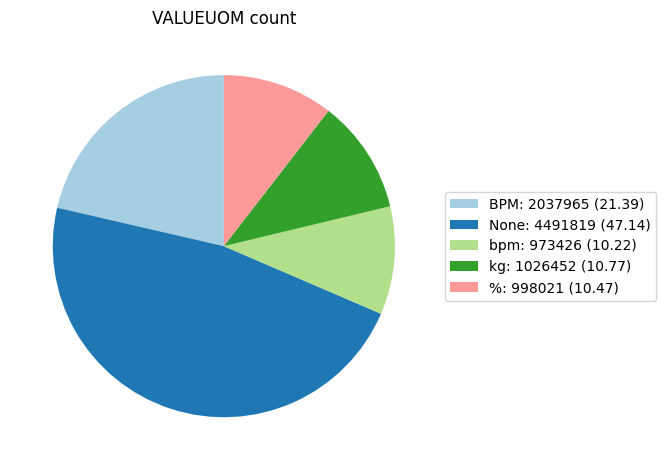

In [ ]:
chartevents_valueuom_count_df = table_chartevents_filtered.groupBy('VALUEUOM') \
                      .agg(count('*').alias('total')).toPandas()
create_pie_graph("VALUEUOM count",chartevents_valueuom_count_df.total, chartevents_valueuom_count_df.VALUEUOM)

In [ ]:
result_df = table_chartevents_filtered.filter(
    (table_chartevents_filtered.VALUENUM.isNotNull()) & (table_chartevents_filtered.VALUEUOM.isNotNull())
).groupBy("VALUEUOM").agg(
    min("VALUENUM").alias("min_valuenum"),
    expr("percentile_approx(VALUENUM, 0.5)").alias("median_valuenum"),
    max("VALUENUM").alias("max_valuenum")
)

result_df.show()

+--------+------------+---------------+------------+
|VALUEUOM|min_valuenum|median_valuenum|max_valuenum|
+--------+------------+---------------+------------+
|     BPM|         0.0|           53.0|       300.0|
|     bpm|         0.0|           89.0|       941.0|
|      kg|         1.0|            1.0|         1.0|
|       %|         0.0|           98.0|       102.0|
+--------+------------+---------------+------------+



- We can see that there is data where the BMP, which represents the number of beats per minute, is equal to 0. This can mean 2 things, either that the person had a cardiac arrest (or died or came back after that arrest) or it is data that were entered incorrectly. How can we be more or less sure of this? Seeing if the person had a follow-up observation whether they had an observation with BPM being equal to 0 or not. If there was no other observation after that, and it is still within the 2-day observation period, then it means that the person probably died. We will confirm this later by combining this table with the admission table. If there was an observation after the BPM was equal to 0, then we will have to look at the D_ITEM table to understand what happened, if the related item does not make sense, then it was probably an imputation error and we will have to remove it to avoid causing problems. This will also be a further analysis, where we will see the joining of the current table with D_ITEM.



- When looking at the table we can see other things that catch our attention, now follows a more specific analysis of these parts

##### First analysis of result_df

- Looking at the table we can see in this last table the presence of both “bpm” and “BPM”, which can either mean the same thing as one being about breathing and the other about heartbeat.   If both acronyms mean the same thing, the ideal would be to rename these 2 columns with the same name, “BPM”, otherwise, make a name that is easier to understand. But first, to confirm if they really are the same thing, I will look at the related ITEMS, if they have a lot of items in common, then it really means that they are 2 classifications that, due to some bad writing, were split into 2. As we are only analyzing this table, we will only do this analysis using the item ids and see the frequency that appears in each type of class (“BPM” and “bpm”).

In [ ]:
result_df_bpm = (table_chartevents_filtered
                 .filter(col("VALUEUOM") == "bpm")
                 .groupBy("ITEMID")
                 .count()
                 .withColumnRenamed("count", "frequency")
                 .orderBy(col("frequency").desc()))

# Mostrando os resultados
result_df_bpm.show()

+------+---------+
|ITEMID|frequency|
+------+---------+
|220045|   785388|
|   211|   188038|
+------+---------+



In [ ]:
result_df_BPM = (table_chartevents_filtered
                 .filter(col("VALUEUOM") == "BPM")
                 .groupBy("ITEMID")
                 .count()
                 .withColumnRenamed("count", "frequency")
                 .orderBy(col("frequency").desc()))

# Mostrando os resultados
result_df_BPM.show()

+------+---------+
|ITEMID|frequency|
+------+---------+
|   211|  1034478|
|   618|  1003487|
+------+---------+



- Since there is an item in each option column that is not in the other table, we cannot draw a conclusion at this point without looking at the D_ITEM table. Therefore, for now it will be left as 2 distinct classes, so that when we do the analysis using the D_ITEM table, we can take a better look at whether the two classes really mean the same thing.

- Another important thing is that once we saw that there is a possible difference between BPM and bpm, then an analysis cannot be carried out just using this table in isolation, because if we are dealing with breaths per minute, this value will be much lower than the than if we are dealing with beats for minutes, preventing us from getting an idea now. What we can see is whether, through the distribution of each type, we can have a more or less idea of ​​what it is about

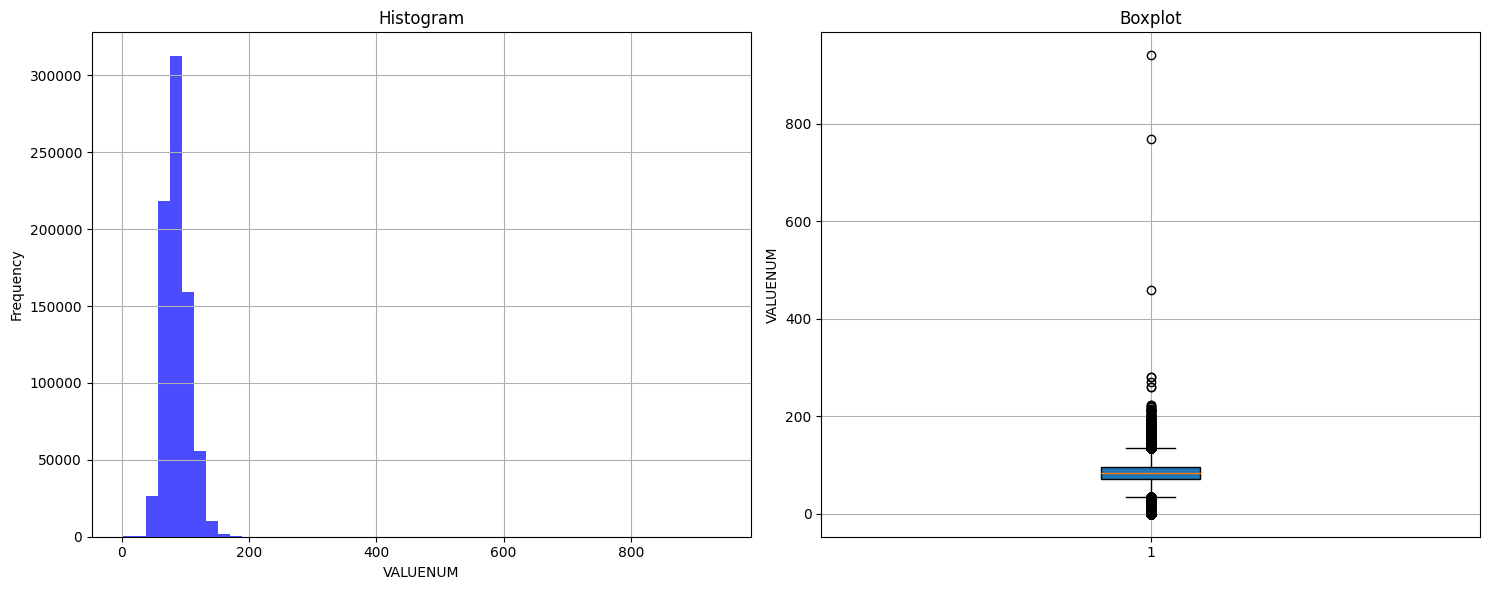

In [ ]:
bpm_values_220045_pd = table_chartevents_filtered.filter((col("ITEMID") == "220045") & (col("VALUEUOM") == "bpm") & (table_chartevents_filtered.VALUENUM.isNotNull())).select("ROW_ID","VALUENUM").toPandas()
plot_hist_and_boxplot(bpm_values_220045_pd, "VALUENUM")

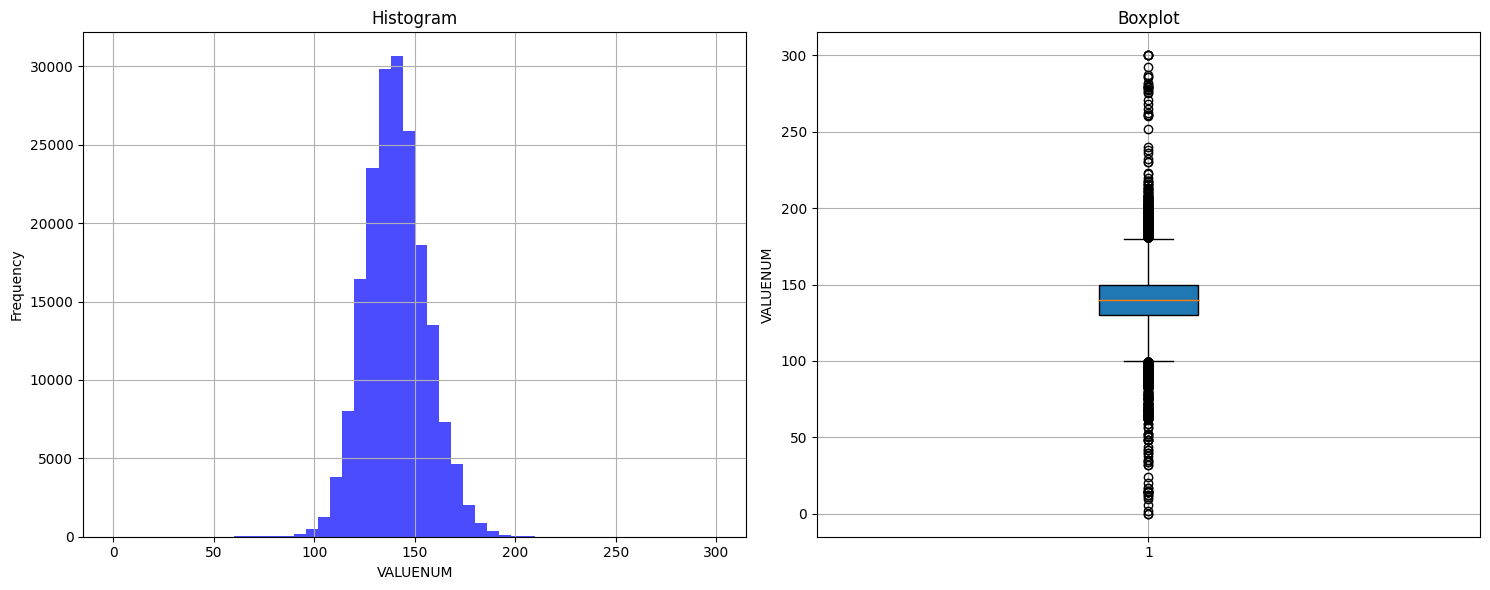

In [ ]:
bpm_values_211_pd = table_chartevents_filtered.filter((col("ITEMID") == "211") & (col("VALUEUOM") == "bpm") & (table_chartevents_filtered.VALUENUM.isNotNull())).select("ROW_ID","VALUENUM").toPandas()
plot_hist_and_boxplot(bpm_values_211_pd, "VALUENUM")

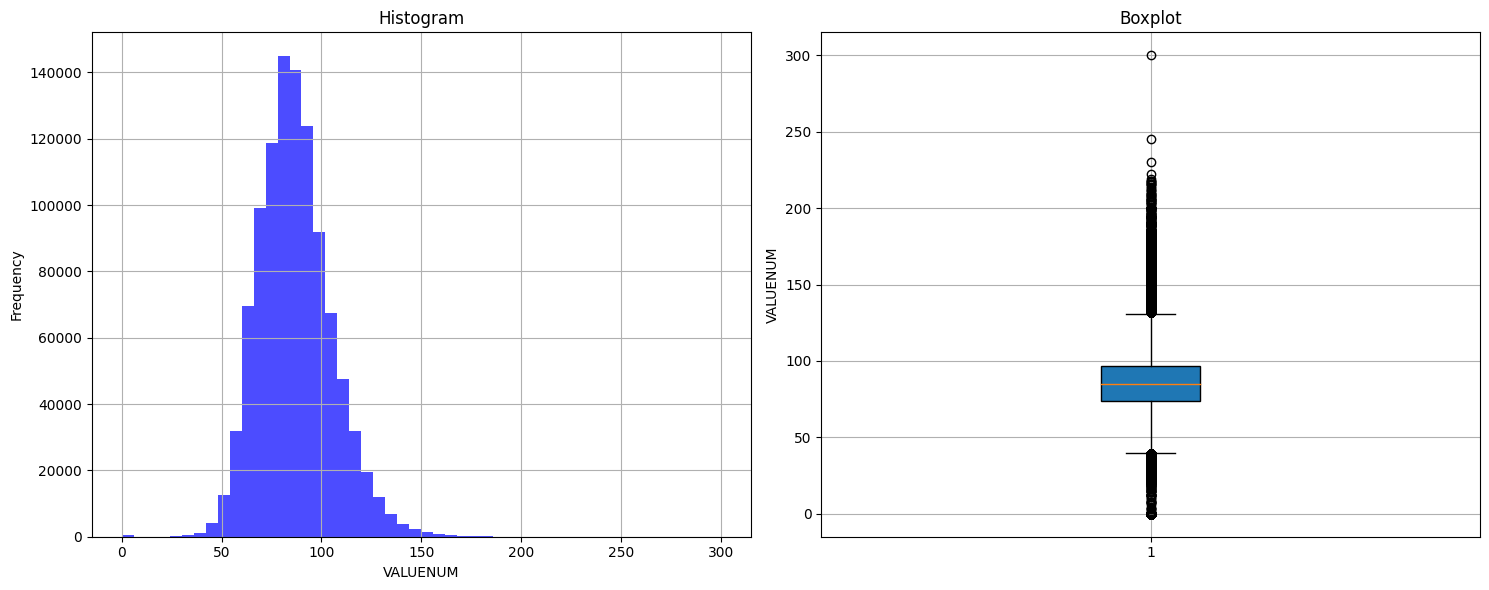

In [ ]:
BPM_values_211_pd = table_chartevents_filtered.filter((col("ITEMID") == "211") & (col("VALUEUOM") == "BPM") & (table_chartevents_filtered.VALUENUM.isNotNull())).select("ROW_ID","VALUENUM").toPandas()
plot_hist_and_boxplot(BPM_values_211_pd, "VALUENUM")

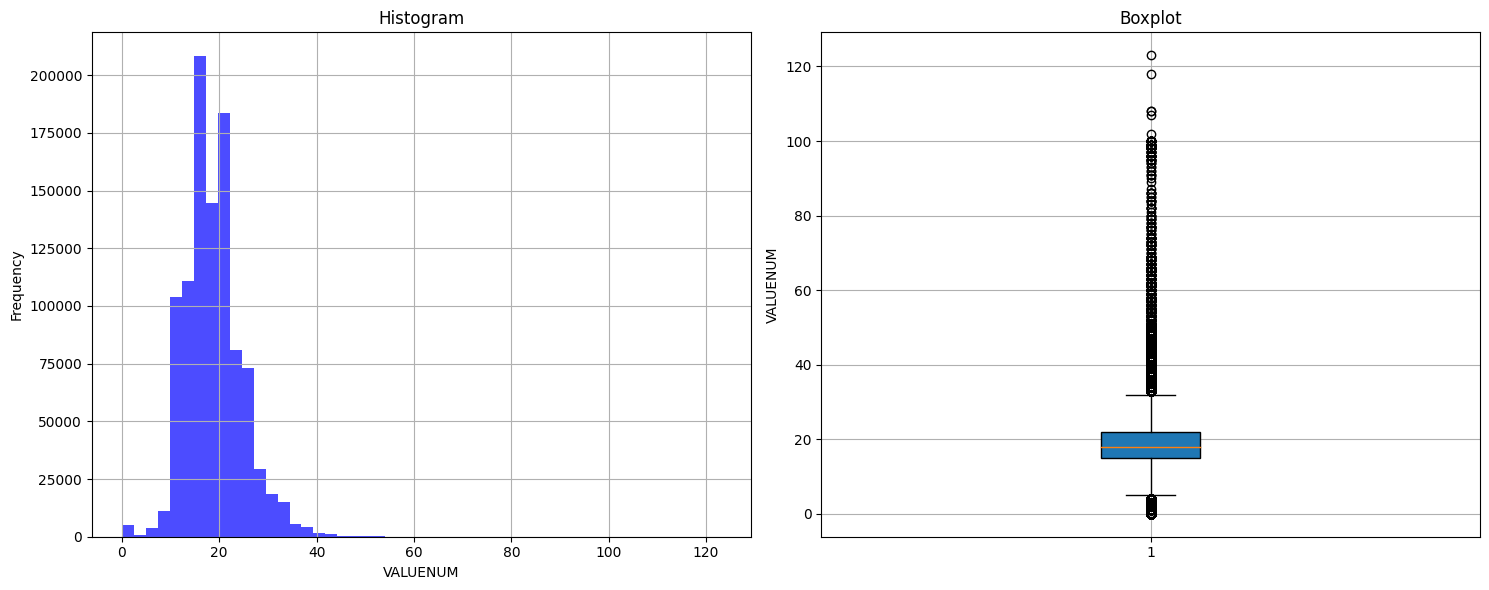

In [ ]:
BPM_values_618_pd = table_chartevents_filtered.filter((col("ITEMID") == "618") & (col("VALUEUOM") == "BPM") & (table_chartevents_filtered.VALUENUM.isNotNull())).select("ROW_ID","VALUENUM").toPandas()
plot_hist_and_boxplot(BPM_values_618_pd, "VALUENUM")

By analyzing the previous graphs, we can have the following notions
- ITEMID 220045 has large outliers
- ITEMID 211 for bpm and BPM follows has a different centrality, where for BPM the center is around 70 while for good it is around 130 or so.
- When it comes to ITEMID being 618, we can see a greater difference in values, which can then be related to breathing

#### Group By: ITEMID

In [ ]:
chartevents_itemid_count = table_chartevents_filtered.groupBy('ITEMID') \
                      .agg(count('*').alias('total'))\
                      .orderBy("total", ascending=False)

In [ ]:
chartevents_itemid_count.show()

+------+-------+
|ITEMID|  total|
+------+-------+
|   211|1222516|
|   742|1026452|
|   618|1003538|
|   646| 998026|
|   212| 973954|
|   161| 950726|
|   128| 876820|
|   550| 869674|
|  1125| 820589|
|220045| 785388|
+------+-------+



In [ ]:
extended_subjects_df = table_chartevents_filtered.groupBy("ITEMID").agg(
    countDistinct("SUBJECT_ID").alias("unique_subjects"),
    count("SUBJECT_ID").alias("total_records")
).orderBy("unique_subjects", ascending=False)

# Mostrando os resultados
extended_subjects_df.show()

+------+---------------+-------------+
|ITEMID|unique_subjects|total_records|
+------+---------------+-------------+
|   211|          29776|      1222516|
|   742|          22238|      1026452|
|   212|          22234|       973954|
|   646|          22229|       998026|
|   618|          22218|      1003538|
|   161|          22217|       950726|
|   128|          21112|       876820|
|   550|          20898|       869674|
|  1125|          19739|       820589|
|220045|          15937|       785388|
+------+---------------+-------------+



We can see a large presence of the item 211, later on we will see better which item this is

#### Update Table

In [ ]:
tables_loaded["chartevents_filtered"] = table_chartevents_filtered

### Table patients

In [ ]:
table_patients = tables_loaded["patients"]

#### DOD/DOD_SSN/DOD_HOSP

In [ ]:
get_null_count_per_columns(table_patients)

Column ROW_ID has 0 null values.
Column SUBJECT_ID has 0 null values.
Column GENDER has 0 null values.
Column DOB has 0 null values.
Column DOD has 30761 null values.
Column DOD_HOSP has 36546 null values.
Column DOD_SSN has 33142 null values.
Column EXPIRE_FLAG has 0 null values.


Looking at the null values we can see a large amount in the columns DOD, DOD_HOSP, DOD_SSN- This should happen due to survival of patient but further analysis is done in this section. DOD merges together DOD_HOSP and DOD_SSN thus the fewer NULL values.

In [ ]:
DOD_null = table_patients.where(isnull("DOD"))
DOD_null.show()

+------+----------+------+-------------------+----+--------+-------+-----------+
|ROW_ID|SUBJECT_ID|GENDER|                DOB| DOD|DOD_HOSP|DOD_SSN|EXPIRE_FLAG|
+------+----------+------+-------------------+----+--------+-------+-----------+
|   234|       249|     F|2075-03-13 00:00:00|NULL|    NULL|   NULL|          0|
|   238|       253|     F|2089-11-26 00:00:00|NULL|    NULL|   NULL|          0|
|   242|       258|     F|2124-09-19 00:00:00|NULL|    NULL|   NULL|          0|
|   243|       260|     F|2105-03-23 00:00:00|NULL|    NULL|   NULL|          0|
|   247|       264|     F|2162-11-30 00:00:00|NULL|    NULL|   NULL|          0|
|   249|       266|     F|2090-12-17 00:00:00|NULL|    NULL|   NULL|          0|
|   250|       267|     F|2131-09-05 00:00:00|NULL|    NULL|   NULL|          0|
|   626|       663|     F|2086-05-12 00:00:00|NULL|    NULL|   NULL|          0|
|   630|       667|     F|2053-09-17 00:00:00|NULL|    NULL|   NULL|          0|
|   638|       675|     F|21

In [ ]:
get_null_count_per_columns(DOD_null)

Column ROW_ID has 0 null values.
Column SUBJECT_ID has 0 null values.
Column GENDER has 0 null values.
Column DOB has 0 null values.
Column DOD has 30761 null values.
Column DOD_HOSP has 30761 null values.
Column DOD_SSN has 30761 null values.
Column EXPIRE_FLAG has 0 null values.


As expected due to the DOD column being the merging of DOD_HOSP and DOD_SSN we can see that the null values are equal between these columns when creating a table consisting of only DOD null values.

In [ ]:
DODH_null = table_patients.where(isnull("DOD_HOSP"))

In [ ]:
get_null_count_per_columns(DODH_null)

Column ROW_ID has 0 null values.
Column SUBJECT_ID has 0 null values.
Column GENDER has 0 null values.
Column DOB has 0 null values.
Column DOD has 30761 null values.
Column DOD_HOSP has 36546 null values.
Column DOD_SSN has 30761 null values.
Column EXPIRE_FLAG has 0 null values.


In [ ]:
DODS_null = table_patients.where(isnull("DOD_SSN"))

In [ ]:
get_null_count_per_columns(DODS_null)

Column ROW_ID has 0 null values.
Column SUBJECT_ID has 0 null values.
Column GENDER has 0 null values.
Column DOB has 0 null values.
Column DOD has 30761 null values.
Column DOD_HOSP has 30761 null values.
Column DOD_SSN has 33142 null values.
Column EXPIRE_FLAG has 0 null values.


There are 5803 patients that are considered alive in the hospital database but are considered dead either by the DOD column or the the DOD_SSN. The reverse is also the case in the column DOD_SSN that contains 2381 patients with a NULL row that have a DOD.

#### Expire Flag

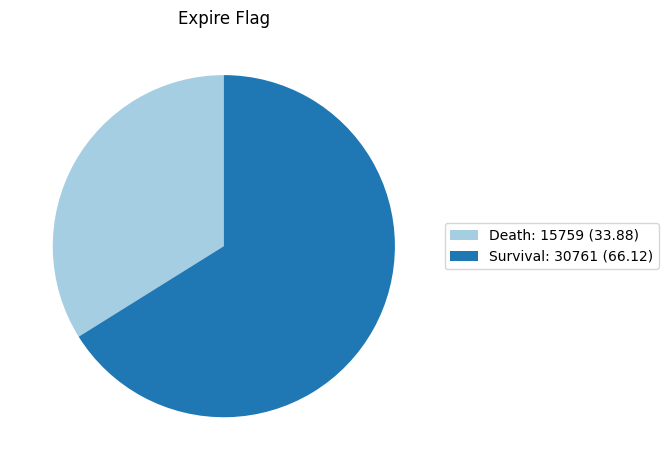

In [ ]:
#pie chart expire flag
ef_count = table_patients.groupBy('EXPIRE_FLAG').agg(count('*').alias('total')).orderBy("total")


ef_count_df =  ef_count.toPandas()
label_map = {0: "Survival", 1: "Death"}
ef_count_df['EXPIRE_FLAG'] = ef_count_df['EXPIRE_FLAG'].map(label_map)
create_pie_graph("Expire Flag",ef_count_df.total,ef_count_df.EXPIRE_FLAG)

Looking at the pie chart differentiating the surviving patients from the dead ones, we can see that there is more survivng patients than dead ones. This gives us a more clear representation of healthcare outcomes, where there is a higher survival rate than mortality rate more specifically 66.12%.The number of surviving patients is also 30761 the same as the ammount of DOD Null values, meaning there are no abnormalities when it comes to Null values from the DOD column that have an Expired Flag stated as the patient dying.

#### Gender

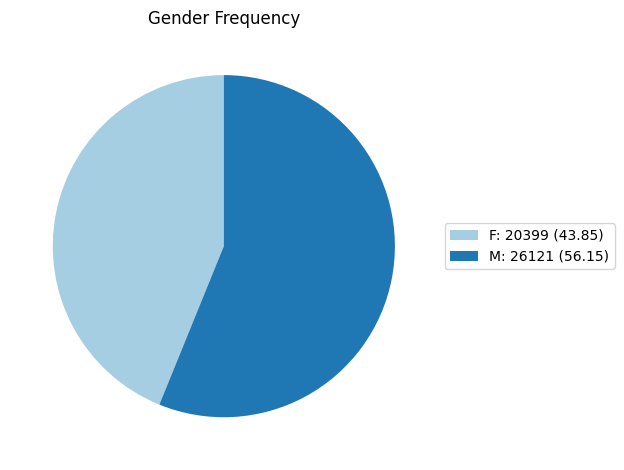

In [ ]:
#pie chart gender
gender_count = table_patients.groupBy('GENDER').agg(count('*').alias('total')).orderBy("total")

gender_count_df =  gender_count.toPandas()
create_pie_graph("Gender Frequency",gender_count_df.total,gender_count_df.GENDER)

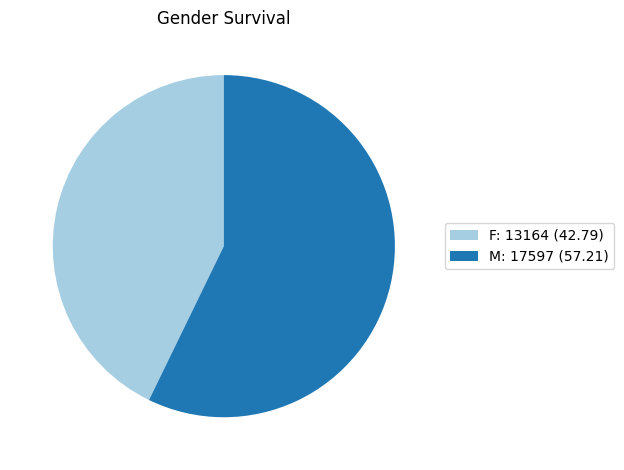

In [ ]:
g_count = DOD_null.groupBy('GENDER').agg(count('*').alias('total')).orderBy("total")
g_count_df =  g_count.toPandas()
create_pie_graph("Gender Survival",g_count_df.total,g_count_df.GENDER)

Looking at the data from the perspectives of Gender, we can see that there is only a slight difference in people from different genders being admitted. Comapring the survival rates we can see that the difference in percentage of surviving patients is near identical to the difference in frequency of patients admitted. This shows us that gender has no effect on survival rates of patients

 ## Cross-Table Analysis

### Table CHARTEVENTS vs Table D_ITEMS



In [ ]:
chartevents = tables_loaded["chartevents_filtered"]
d_items = tables_loaded["items"]


#### Pre Processing

In [ ]:
joined_df = chartevents.join(
    d_items,
    chartevents["ITEMID"] == d_items["ITEMID"],
    "inner"
).select(
    chartevents["*"],
    d_items["LABEL"],
)




In [ ]:
joined_df.show()

+--------+----------+-------+----------+------+-------------------+-------------------+----------------+--------+--------+----------------+
|  ROW_ID|SUBJECT_ID|HADM_ID|ICUSTAY_ID|ITEMID|          CHARTTIME|          STORETIME|           VALUE|VALUENUM|VALUEUOM|           LABEL|
+--------+----------+-------+----------+------+-------------------+-------------------+----------------+--------+--------+----------------+
|34303753|         2| 163353|  243653.0|   211|2138-07-17 20:20:00|2138-07-17 22:07:00|             148|   148.0|     bpm|      Heart Rate|
|34303794|         2| 163353|  243653.0|   211|2138-07-17 22:00:00|2138-07-17 22:08:00|             140|   140.0|     bpm|      Heart Rate|
|34303781|         2| 163353|  243653.0|   211|2138-07-17 21:00:00|2138-07-17 22:08:00|             144|   144.0|     bpm|      Heart Rate|
|34303772|         2| 163353|  243653.0|   211|2138-07-17 20:30:00|2138-07-17 22:07:00|             131|   131.0|     bpm|      Heart Rate|
|34305105|         3

#### BPM vs bpm

As discussed before, currently there is a bpm and BPM value for the "VALUEUOM" column, however it is not possible to say whether they represent the same thing or not, so now that we have the D_ITEMS table, what will be done is to see the true values of this value, to know if it is really related to the same thing

In [ ]:
result_df_bpm = (joined_df
                 .filter(col("VALUEUOM") == "bpm")
                 .groupBy("ITEMID", "LABEL")
                 .count()
                 .withColumnRenamed("count", "frequency")
                 .orderBy(col("frequency").desc()))

# Mostrando os resultados
result_df_bpm.show()

+------+----------+---------+
|ITEMID|     LABEL|frequency|
+------+----------+---------+
|220045|Heart Rate|   785388|
|   211|Heart Rate|   188038|
+------+----------+---------+



In [ ]:
result_df_BPM = (joined_df
                 .filter(col("VALUEUOM") == "BPM")
                 .groupBy("ITEMID", "LABEL")
                 .count()
                 .withColumnRenamed("count", "frequency")
                 .orderBy(col("frequency").desc()))

# Mostrando os resultados
result_df_BPM.show()


+------+----------------+---------+
|ITEMID|           LABEL|frequency|
+------+----------------+---------+
|   211|      Heart Rate|  1034478|
|   618|Respiratory Rate|  1003487|
+------+----------------+---------+



Therefore, what we can see is that ITEMID 220045 and 211 are related to heartbeats while 618 is related to breathing, as suspected. Therefore, what we have to do now is to rename the values, this way there will no longer be a possible mix of values ​​when carrying out the analysis

In [ ]:
joined_df = joined_df.withColumn(
    "VALUEUOM",
    F.when(
        (F.col("VALUEUOM") == "bpm") & (F.col("LABEL").like("%Heart%")),
        "BPM"
    ).otherwise(F.col("VALUEUOM"))
)

# Introduzindo "BrPM" para frequências respiratórias
joined_df = joined_df.withColumn(
    "VALUEUOM",
    F.when(
        (F.col("VALUEUOM").isin("BPM", "bpm")) & (F.col("LABEL").like("%Respiratory%")),
        "BrPM"
    ).otherwise(F.col("VALUEUOM"))
)

In [ ]:
joined_df.filter(col("VALUEUOM") == "BPM").groupBy("ITEMID", "LABEL").count().withColumnRenamed("count", "frequency").orderBy(col("frequency").desc()).show()



+------+----------+---------+
|ITEMID|     LABEL|frequency|
+------+----------+---------+
|   211|Heart Rate|  1222516|
|220045|Heart Rate|   785388|
+------+----------+---------+



In [ ]:
joined_df.filter(col("VALUEUOM") == "BrPM").groupBy("ITEMID", "LABEL").count().withColumnRenamed("count", "frequency").orderBy(col("frequency").desc()).show()


+------+----------------+---------+
|ITEMID|           LABEL|frequency|
+------+----------------+---------+
|   618|Respiratory Rate|  1003487|
+------+----------------+---------+



#### BPM outliers

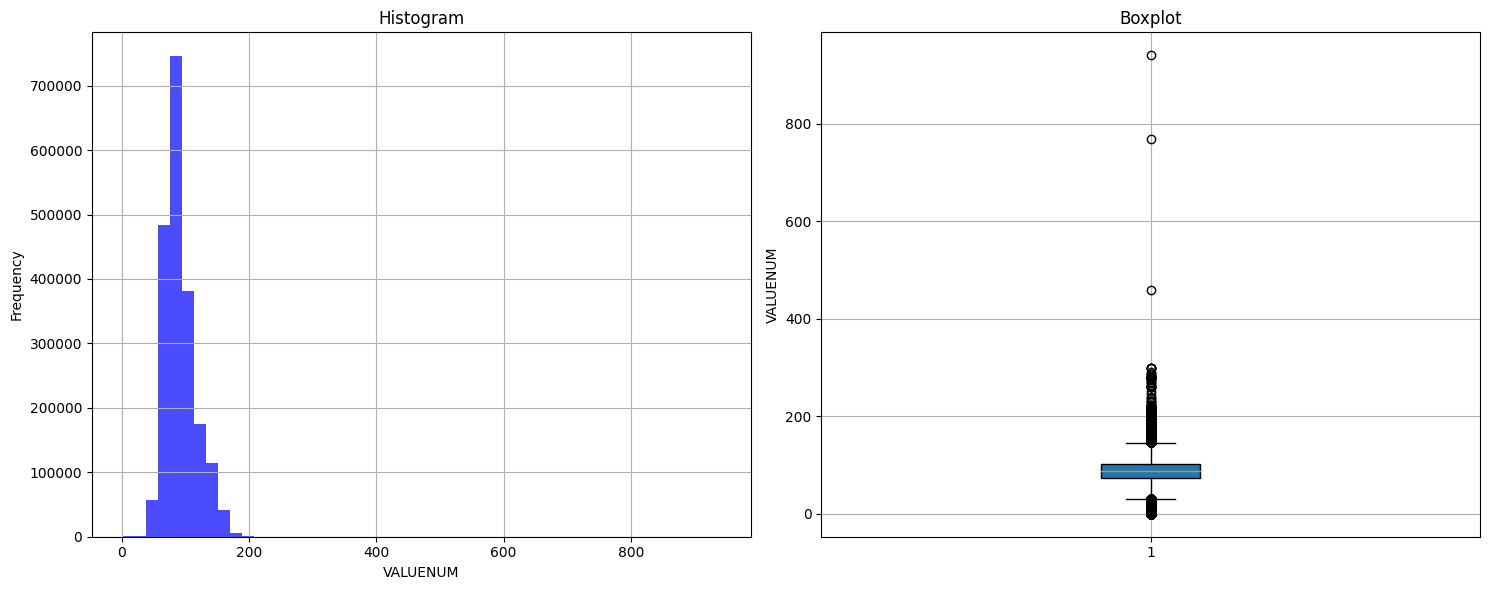

In [ ]:
BPM_values_pd = joined_df.filter((col("VALUEUOM") == "BPM") & (joined_df.VALUENUM.isNotNull())).select("ROW_ID","VALUENUM").toPandas()
plot_hist_and_boxplot(BPM_values_pd, "VALUENUM")

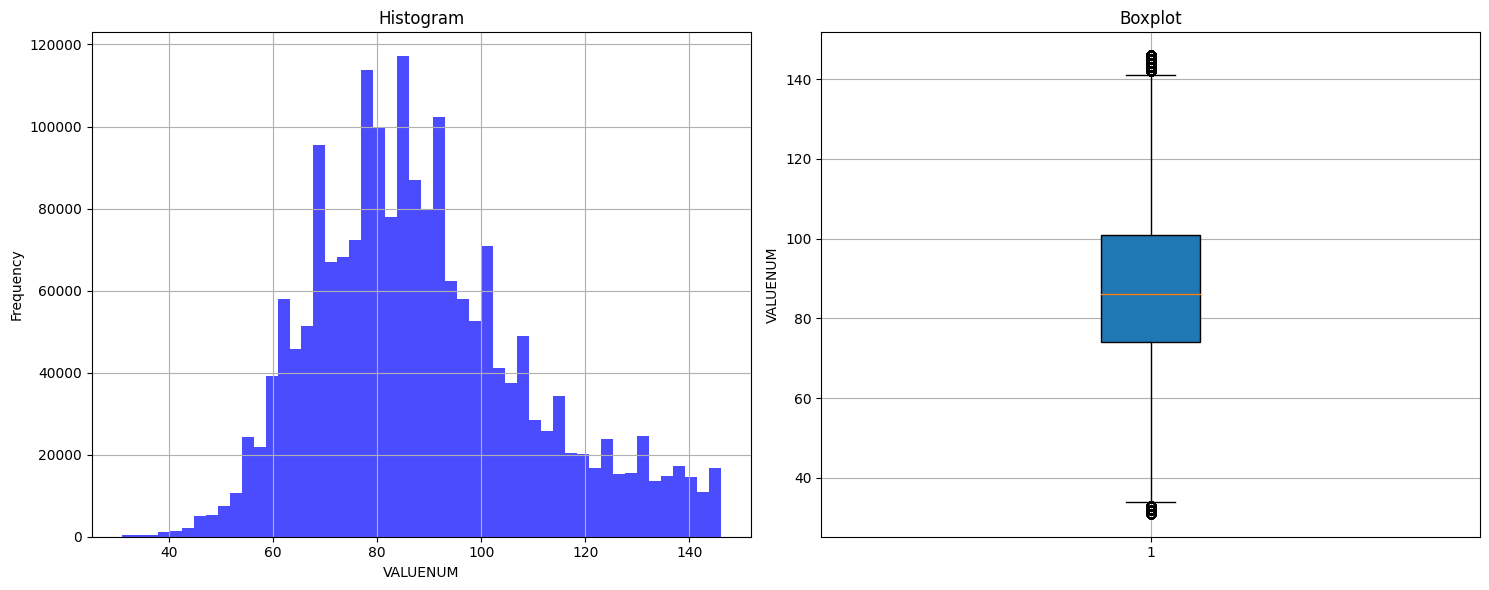

In [ ]:
filtered_data, outliers_data =  get_data_with_and_without_outliers(BPM_values_pd,"VALUENUM")
plot_hist_and_boxplot(filtered_data,"VALUENUM")

We can see that despite removing the outliers, we still saw some, but since we have an improvement, we will leave it that way so as not to remove too much data.

In [ ]:
print(f"Total to be removed: {len(outliers_data)}")

Total to be removed: 66935


In [ ]:
outliers_spark = spark.createDataFrame(outliers_data)
joined_df = joined_df.join(outliers_spark, ["ROW_ID"], "left_anti")

#### BrPM outliers

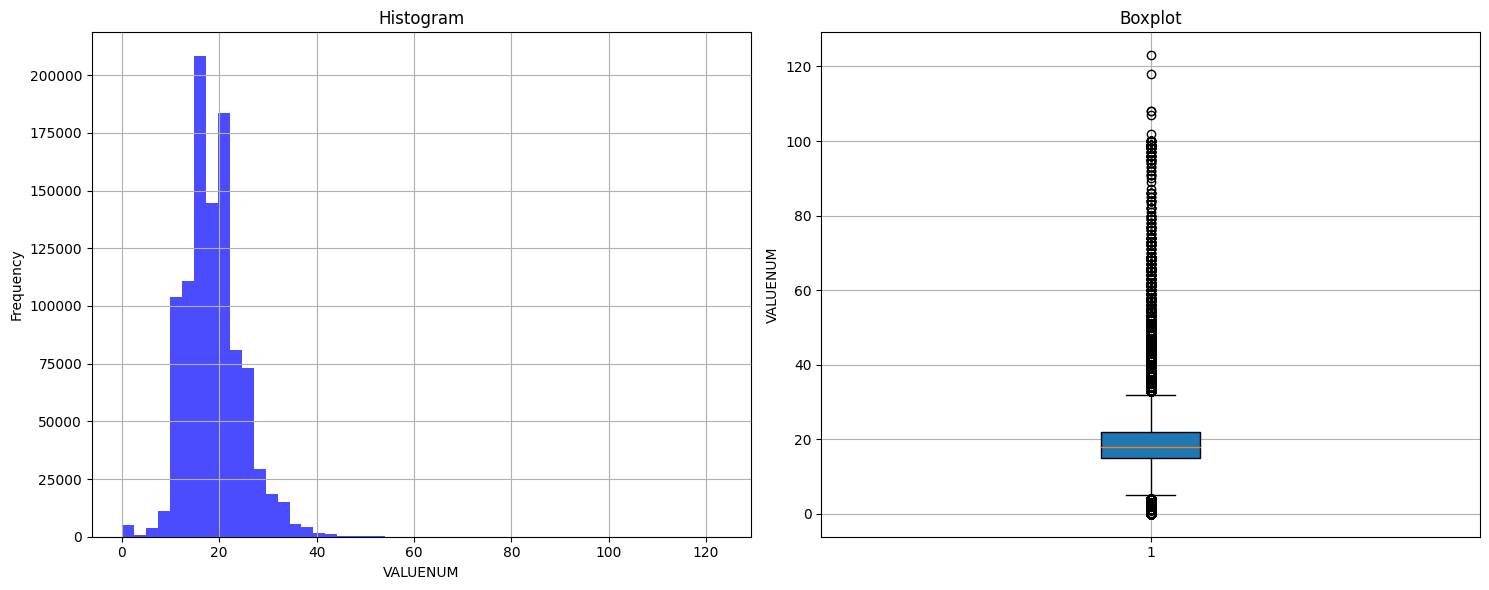

In [ ]:
BrPM_values_pd = joined_df.filter((col("VALUEUOM") == "BrPM") & (joined_df.VALUENUM.isNotNull())).select("ROW_ID","VALUENUM").toPandas()
plot_hist_and_boxplot(BrPM_values_pd, "VALUENUM")

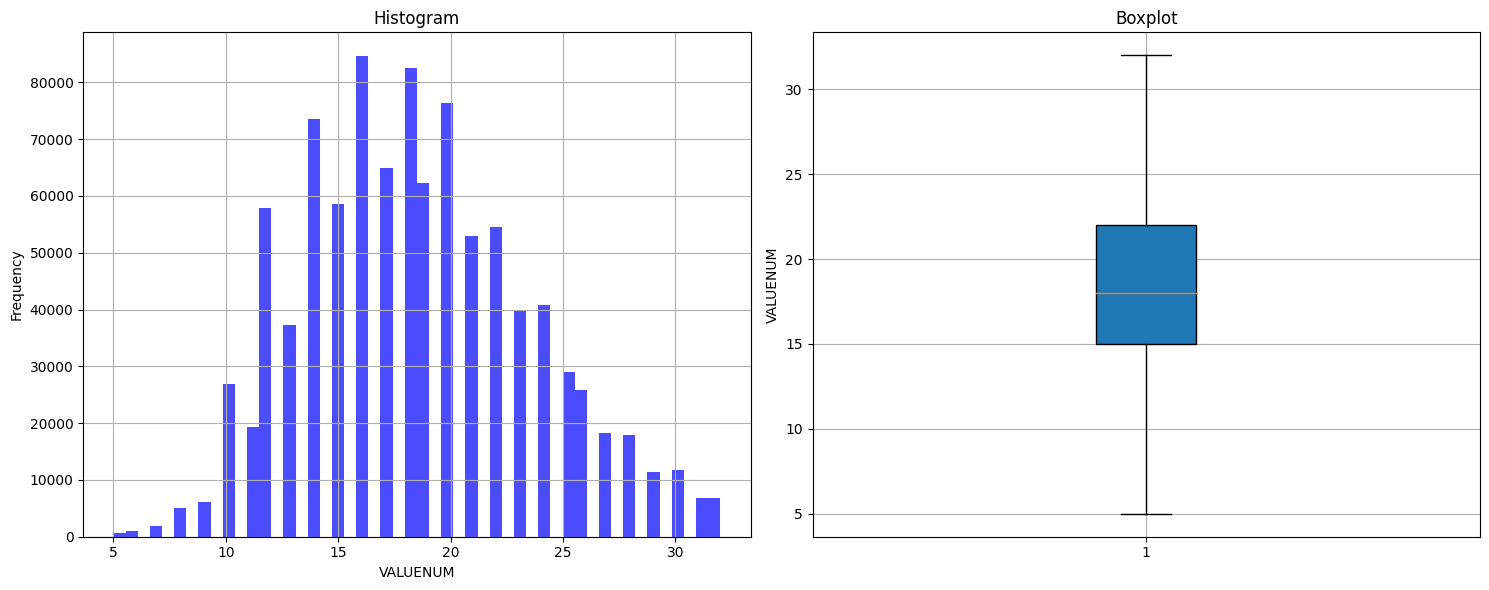

In [ ]:
filtered_data, outliers_data =  get_data_with_and_without_outliers(BrPM_values_pd,"VALUENUM")
plot_hist_and_boxplot(filtered_data,"VALUENUM")

Once we remove the outliers, we can see a representation tending to a normal

In [ ]:
print(f"Total to be removed: {len(outliers_data)}")


Total to be removed: 28106


In [ ]:
outliers_spark = spark.createDataFrame(outliers_data)
joined_df = joined_df.join(outliers_spark, ["ROW_ID"], "left_anti")

#### Categorical and Numerical values

##### Categorical Values

In [ ]:
categorical_value_frequency = (joined_df
    .filter(col("VALUENUM").isNull())
    .groupBy("VALUE", "LABEL")
    .count()
    .withColumnRenamed("count", "frequency")
    .orderBy(col("frequency").desc()))
categorical_value_frequency_pd = categorical_value_frequency.toPandas().head(20)

In [ ]:
categorical_value_frequency_pd

,VALUE,LABEL,frequency
0,Full Code,Code Status,815611
1,None,Ectopy Type,814749
2,Universal,Precautions,803517
3,Normal Sinus,Heart Rhythm,590412
4,MICU,Service Type,197456
5,CSRU,Service Type,191782
6,Sinus Tachy,Heart Rhythm,161358
7,NSICU,Service Type,143261
8,CCU,Service Type,108255
9,PVC's,Ectopy Type,99350


<Figure size 1000x1000 with 0 Axes>

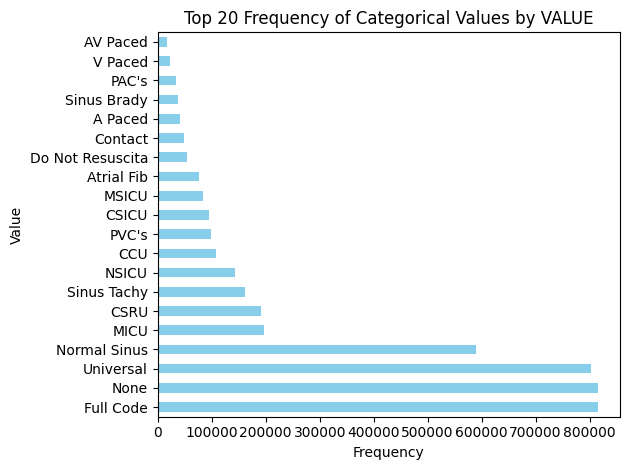

In [ ]:
plt.figure(figsize=(10, 10))  # Ajuste o tamanho conforme a necessidade
categorical_value_frequency_pd.plot(kind='barh', x='VALUE', y='frequency', color='skyblue', legend=None)
plt.title('Top 20 Frequency of Categorical Values by VALUE')
plt.xlabel('Frequency')
plt.ylabel('Value')
plt.tight_layout()  # Ajusta o layout para não cortar elementos gráficos

# Mostrar o gráfico
plt.show()

<Figure size 1000x1000 with 0 Axes>

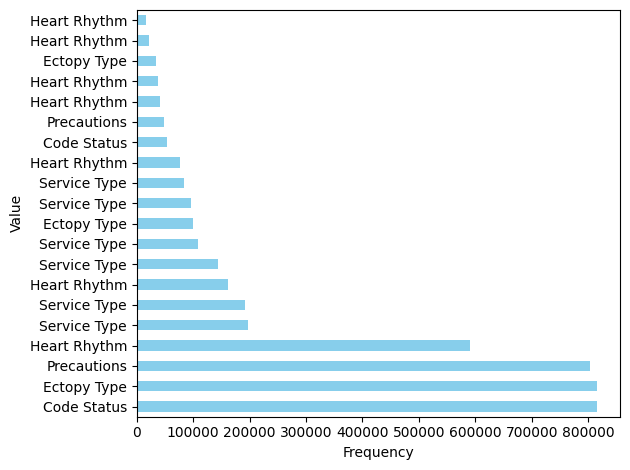

In [ ]:
plt.figure(figsize=(10, 10))  # Ajuste o tamanho conforme a necessidade
categorical_value_frequency_pd.plot(kind='barh', x='LABEL', y='frequency', color='skyblue', legend=None)
plt.xlabel('Frequency')
plt.ylabel('Value')
plt.tight_layout()  # Ajusta o layout para não cortar elementos gráficos

# Mostrar o gráfico
plt.show()

obs: In the first graph we can see almost the most categorical values ​​are repeated, while in the second we can see which label they refer to.

We can observe a significant focus on cardiac monitoring within the hospital setting, as evidenced by the high frequency of terms like 'AV Paced', 'V Paced', 'Sinus Brady', and 'Sinus Tachy' in the data. This suggests that heart rhythm management is a critical aspect of patient care in this facility, likely reflecting a patient population with considerable cardiac care needs. Such a trend underscores the importance of cardiac monitoring technologies and expertise in treating conditions that affect heart rhythm.

##### Numerical Values

In [ ]:
numerical_value_frequency = (joined_df
    .filter(col("VALUENUM").isNotNull())
    .groupBy("LABEL")  # ou você pode mudar para 'LABEL' ou outra coluna relevante
    .agg(
        F.count("VALUENUM").alias("count"),
        F.avg("VALUENUM").alias("average"),
        F.stddev("VALUENUM").alias("std_dev"),
        F.min("VALUENUM").alias("min"),
        F.max("VALUENUM").alias("max")
    )
    .orderBy("average", ascending=False)
)
numerical_value_frequency.show()


+----------------+-------+-----------------+------------------+----+-----+
|           LABEL|  count|          average|           std_dev| min|  max|
+----------------+-------+-----------------+------------------+----+-----+
|            SpO2| 996677|97.25625980131518| 3.926762567214996| 0.0|102.0|
|      Heart Rate|1940432| 88.8469001438883|20.955619369263268|31.0|146.0|
|Respiratory Rate| 974928|18.51581503454661| 5.075007311553048| 5.0| 32.0|
|      calprevflg|1025660|              1.0|               0.0| 1.0|  1.0|
+----------------+-------+-----------------+------------------+----+-----+



- SpO2 values, with a total of 996,677 observations, average at 97.26%, typically within the normal range for healthy individuals. However, the presence of values as low as 0% and as high as 102% suggests possible measurement errors or calibration issues, as such extremes are physiologically implausible. This necessitates a review of the monitoring equipment or the procedures used in capturing these readings to ensure data reliability.

- Heart Rate data, derived from a large sample size of 1,940,432 measurements, shows an average rate of 88.85 beats per minute. This is slightly elevated, suggesting potential underlying stress or cardiovascular conditions among the patient population. The substantial variation, indicated by a standard deviation of 20.96, encompasses rates from 31 to 146 beats per minute, covering conditions from bradycardia to severe tachycardia. Such diversity in heart rates underscores the need for individualized patient monitoring and possibly reflects the broad range of clinical scenarios encountered in the hospital setting.

- Respiratory Rate figures, with 974,928 records, present an average rate of 18.52 breaths per minute, aligning with normal adult rates. The variation is moderately high, however, with a standard deviation of 5.08 and values ranging from 5 to 32 breaths per minute. This variability could be influenced by patient age, clinical conditions, or therapeutic interventions and highlights the importance of continuous respiratory monitoring for detecting potential respiratory complicati

######  SpO2


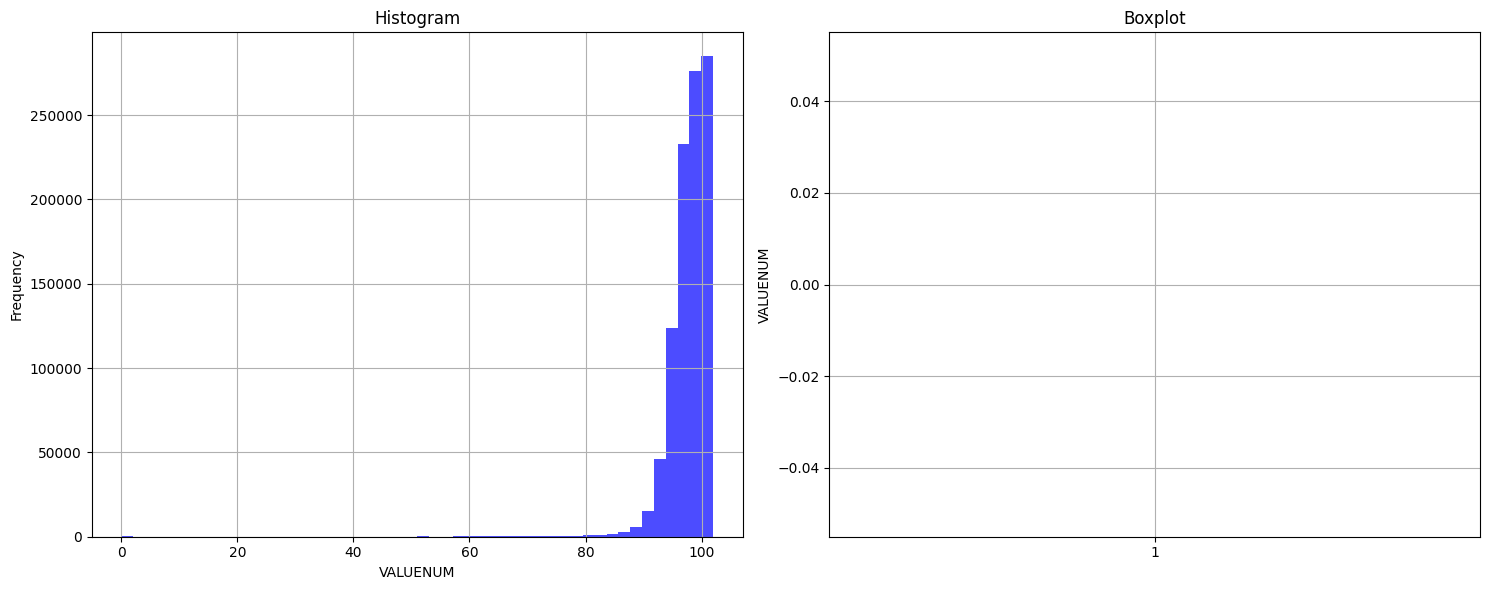

In [ ]:
spo2_values_pd = joined_df.filter((col("LABEL") == "SpO2")).select("ROW_ID","VALUENUM").toPandas()
plot_hist_and_boxplot(spo2_values_pd, "VALUENUM")

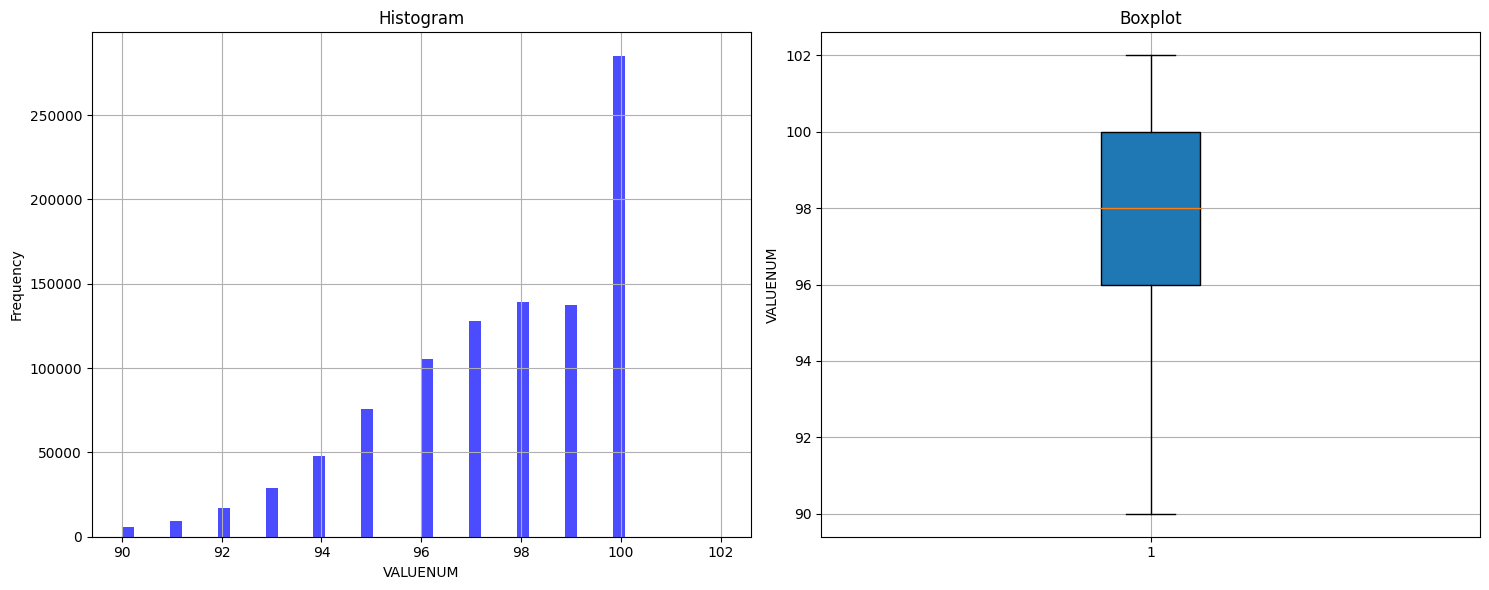

In [ ]:
filtered_data, outliers_data =  get_data_with_and_without_outliers(spo2_values_pd,"VALUENUM")
plot_hist_and_boxplot(filtered_data,"VALUENUM")

We can see that with the removal of outliers, the values ​​tend to reach a number close to 90

In [ ]:
print(f"Total to be removed: {len(outliers_data)}")

Total to be removed: 17786


In [ ]:
outliers_spark = spark.createDataFrame(outliers_data)
joined_df = joined_df.join(outliers_spark, ["ROW_ID"], "left_anti")

#### Update Table

In [ ]:
tables_loaded["chartevents_x_ditems"] = joined_df

### Table Admissions vs Table Patients

In [ ]:
admissions = tables_loaded["admissions"]
patients = tables_loaded["patients"]

In [ ]:
admissions.count()

13143

In [ ]:
admissions.orderBy("SUBJECT_ID").show()

+--------------------+------+----------+-------+-------------------+-------------------+-------------------+--------------+--------------------+--------------------+---------+--------------+-------------------+-------------------+--------------------+--------------------+-----------+------------------+-----+
|           DIAGNOSIS|ROW_ID|SUBJECT_ID|HADM_ID|          ADMITTIME|          DISCHTIME|          DEATHTIME|ADMISSION_TYPE|  ADMISSION_LOCATION|  DISCHARGE_LOCATION|INSURANCE|MARITAL_STATUS|          EDREGTIME|          EDOUTTIME|HOSPITAL_EXPIRE_FLAG|HAS_CHARTEVENTS_DATA|IS_DECEASED|     STAY_DURATION|total|
+--------------------+------+----------+-------+-------------------+-------------------+-------------------+--------------+--------------------+--------------------+---------+--------------+-------------------+-------------------+--------------------+--------------------+-----------+------------------+-----+
|FEVER,DEHYDRATION...|     3|         4| 185777|2191-03-16 00:28:00|21

In [ ]:
patients.show()

+------+----------+------+-------------------+----+--------+-------+-----------+
|ROW_ID|SUBJECT_ID|GENDER|                DOB| DOD|DOD_HOSP|DOD_SSN|EXPIRE_FLAG|
+------+----------+------+-------------------+----+--------+-------+-----------+
|   234|       249|     F|2075-03-13 00:00:00|NULL|    NULL|   NULL|          0|
|   238|       253|     F|2089-11-26 00:00:00|NULL|    NULL|   NULL|          0|
|   242|       258|     F|2124-09-19 00:00:00|NULL|    NULL|   NULL|          0|
|   243|       260|     F|2105-03-23 00:00:00|NULL|    NULL|   NULL|          0|
|   247|       264|     F|2162-11-30 00:00:00|NULL|    NULL|   NULL|          0|
|   249|       266|     F|2090-12-17 00:00:00|NULL|    NULL|   NULL|          0|
|   250|       267|     F|2131-09-05 00:00:00|NULL|    NULL|   NULL|          0|
|   626|       663|     F|2086-05-12 00:00:00|NULL|    NULL|   NULL|          0|
|   630|       667|     F|2053-09-17 00:00:00|NULL|    NULL|   NULL|          0|
|   638|       675|     F|21

#### Pre Processing

In [ ]:
joined_df = admissions.join(
    patients,
    admissions["SUBJECT_ID"] == patients["SUBJECT_ID"],
    "inner"
).select(
    admissions["*"],
    patients["GENDER"],
    patients["DOB"],
    patients["DOD"],
    patients["DOB"],
)

What I will do for our analysis is create a column for the person's age, for people over 89, I am setting their age at 90, given the nature of the data ("Patients who are older than 89 years old at any time in the database have had their date of birth shifted to obscure their age and comply with HIPAA")

In [ ]:
joined_df = joined_df.withColumn(
    "AGE",
    when(
        (datediff(col("ADMITTIME"), col("DOB")) / 365.25) > 89,
        90
    ).otherwise(
        (datediff(col("ADMITTIME"), col("DOB")) / 365.25).cast("int")
    )
)

In [ ]:
joined_df.show()

+--------------------+------+----------+-------+-------------------+-------------------+---------+--------------+--------------------+------------------+----------+--------------+-------------------+-------------------+--------------------+--------------------+-----------+------------------+-----+------+-------------------+-------------------+-------------------+---+
|           DIAGNOSIS|ROW_ID|SUBJECT_ID|HADM_ID|          ADMITTIME|          DISCHTIME|DEATHTIME|ADMISSION_TYPE|  ADMISSION_LOCATION|DISCHARGE_LOCATION| INSURANCE|MARITAL_STATUS|          EDREGTIME|          EDOUTTIME|HOSPITAL_EXPIRE_FLAG|HAS_CHARTEVENTS_DATA|IS_DECEASED|     STAY_DURATION|total|GENDER|                DOB|                DOD|                DOB|AGE|
+--------------------+------+----------+-------+-------------------+-------------------+---------+--------------+--------------------+------------------+----------+--------------+-------------------+-------------------+--------------------+--------------------

#### Age Analysis

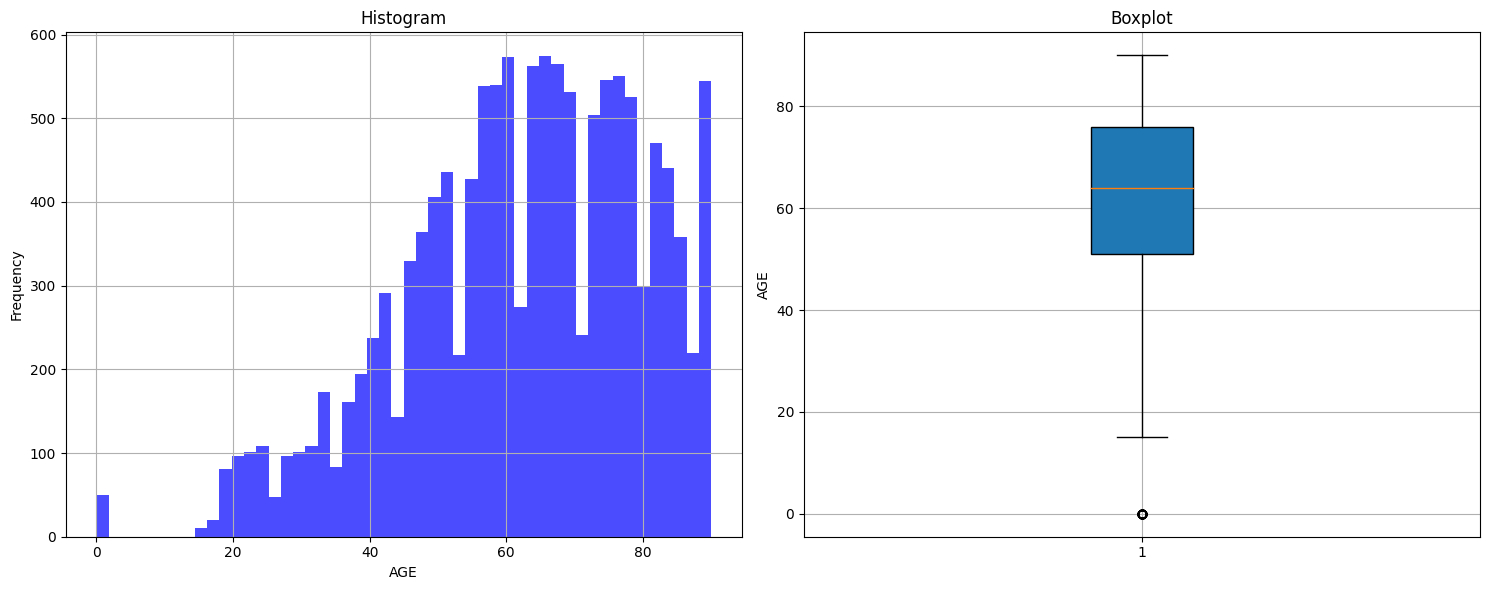

In [ ]:
age_df = joined_df.select("AGE","IS_DECEASED", "GENDER").toPandas()
plot_hist_and_boxplot(age_df, "AGE")


Through the graph we can see a predominance of people over the age of 50, with a small number of cases of babies born

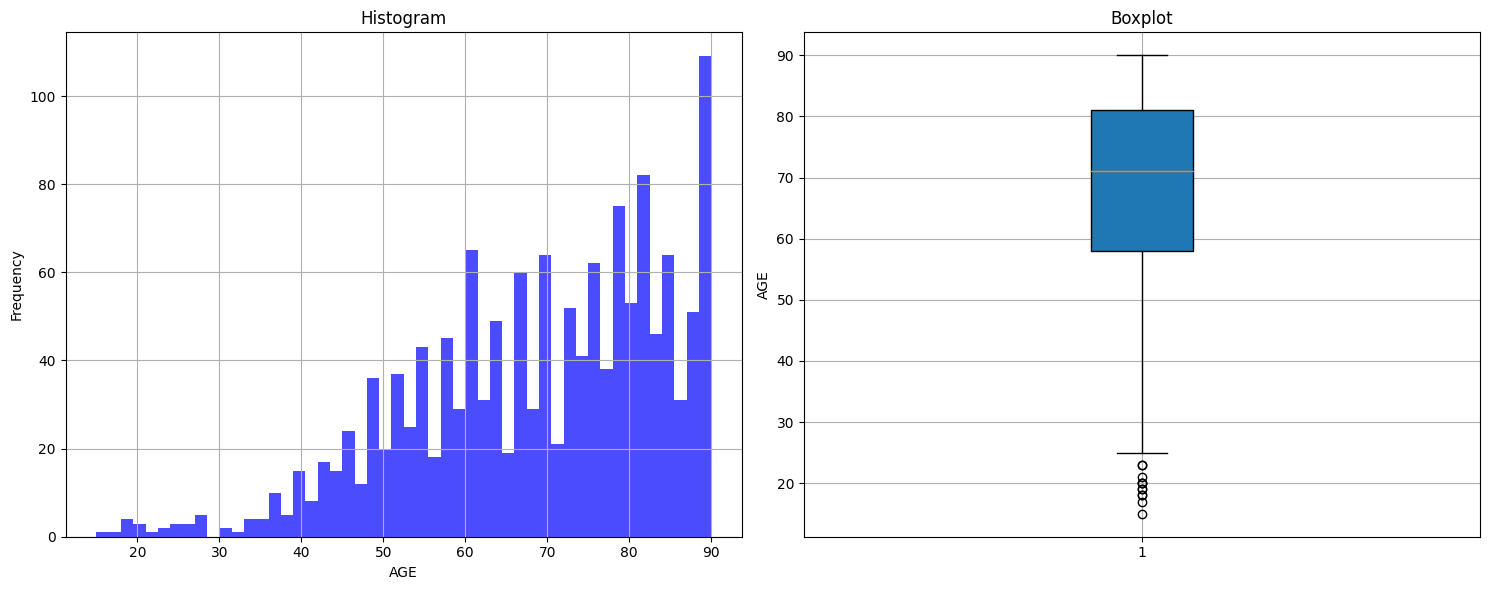

In [ ]:
plot_hist_and_boxplot(age_df[age_df.IS_DECEASED==1], "AGE")


As we can see, people who die under 27 are considered an outlier, which makes sense. We can also see a very high median, around 70, showing that there is a possible relationship between age and possible death.

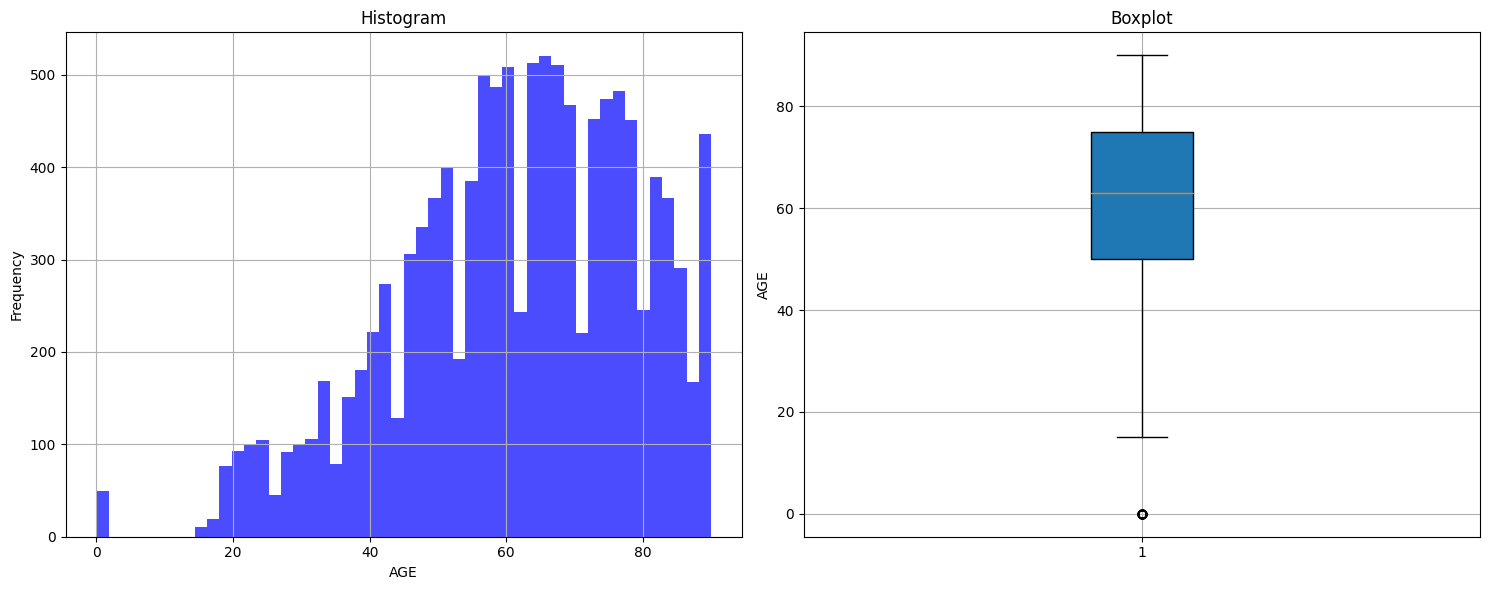

In [ ]:
plot_hist_and_boxplot(age_df[age_df.IS_DECEASED==0], "AGE")


In the previous graph we can see a drop in the median value, showing that people with less chances of living tend to live, although this value is still high due to the lack of young people going to the hospital, as we saw in the first graph

We can also see that compared to the second graph, younger ages tend to have more occurrences in cases where the person survived

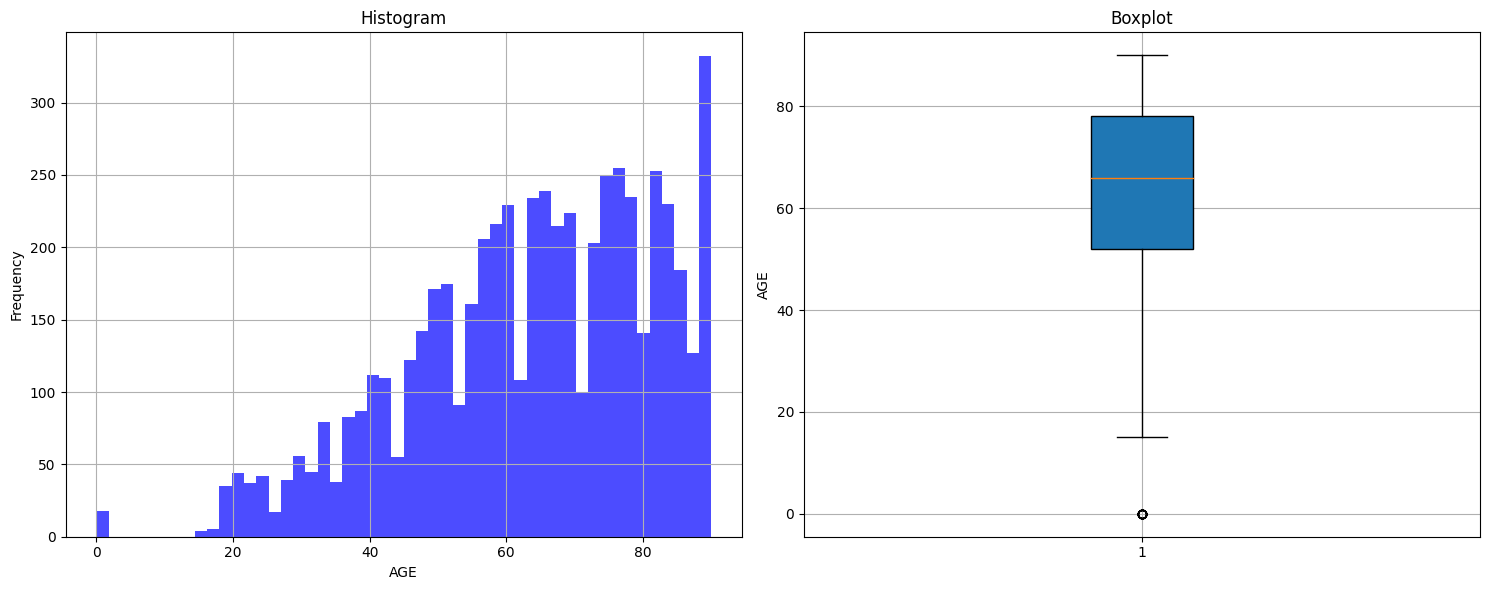

In [ ]:
plot_hist_and_boxplot(age_df[age_df.GENDER=="F"], "AGE")

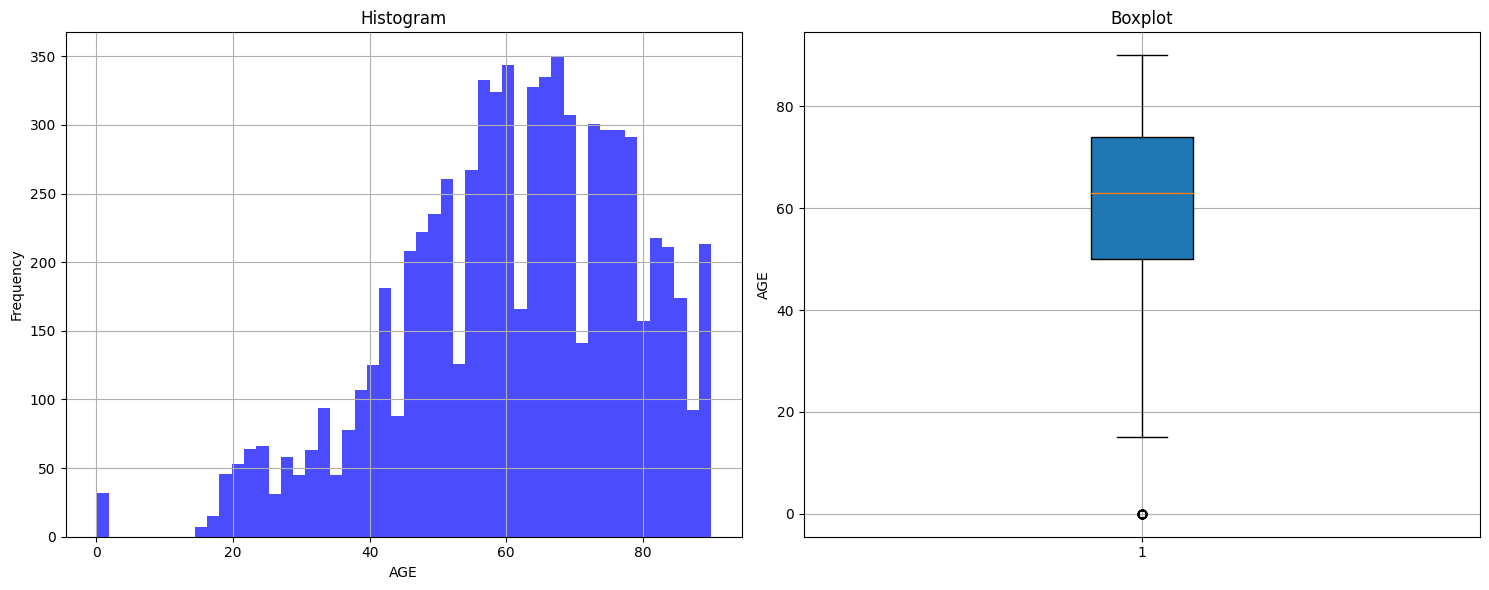

In [ ]:
plot_hist_and_boxplot(age_df[age_df.GENDER=="M"], "AGE")

We can see that the predominance of older people is linked to the female sex, mainly those aged over 89. We can see that the graph for the Male gender tends to be more centered at 60, while for the female gender it does not

In [ ]:
aggregated_ADMISSION_TYPE_df = joined_df.groupBy("ADMISSION_TYPE").agg(
    F.min("AGE").alias("Min_Age"),
    F.expr("percentile_approx(AGE, 0.25)").alias("25th_Percentile_Age"),
    F.expr("percentile_approx(AGE, 0.50)").alias("50th_Percentile_Age"),
    F.expr("percentile_approx(AGE, 0.75)").alias("75th_Percentile_Age"),
    F.expr("percentile_approx(AGE, 0.9)").alias("90th_Percentile_Age"),
    F.expr("percentile_approx(AGE, 0.9)").alias("95th_Percentile_Age"),
    F.max("AGE").alias("Max_Age"),
)
aggregated_ADMISSION_TYPE_df.show()

+--------------+-------+-------------------+-------------------+-------------------+-------------------+-------------------+-------+
|ADMISSION_TYPE|Min_Age|25th_Percentile_Age|50th_Percentile_Age|75th_Percentile_Age|90th_Percentile_Age|95th_Percentile_Age|Max_Age|
+--------------+-------+-------------------+-------------------+-------------------+-------------------+-------------------+-------+
|       NEWBORN|      0|                  0|                  0|                  0|                  0|                  0|      0|
|      ELECTIVE|     17|                 53|                 63|                 74|                 81|                 81|     90|
|     EMERGENCY|      0|                 50|                 64|                 77|                 84|                 84|     90|
|        URGENT|      0|                 53|                 65|                 77|                 83|                 83|     90|
+--------------+-------+-------------------+-------------------+-----

We can see that in all cases, except NEWBORN, at least 75% of those admitted are over 50. This could already be seen from the previous graphs. We can also see that 50% of people are between +-50 and 77 years old, since the difference between the 25th percentile and the 75th percentile represents 50% of the data. We can also see that less than 5% of people admitted are over 85 years old

In [ ]:
aggregated_ADMISSION_LOCATION_df = joined_df.groupBy("ADMISSION_LOCATION").agg(
    F.min("AGE").alias("Min_Age"),
    F.expr("percentile_approx(AGE, 0.25)").alias("25th_Percentile_Age"),
    F.expr("percentile_approx(AGE, 0.50)").alias("50th_Percentile_Age"),
    F.expr("percentile_approx(AGE, 0.75)").alias("75th_Percentile_Age"),
    F.expr("percentile_approx(AGE, 0.9)").alias("90th_Percentile_Age"),
    F.expr("percentile_approx(AGE, 0.9)").alias("95th_Percentile_Age"),
    F.max("AGE").alias("Max_Age"),
)
aggregated_ADMISSION_LOCATION_df.show()

+--------------------+-------+-------------------+-------------------+-------------------+-------------------+-------------------+-------+
|  ADMISSION_LOCATION|Min_Age|25th_Percentile_Age|50th_Percentile_Age|75th_Percentile_Age|90th_Percentile_Age|95th_Percentile_Age|Max_Age|
+--------------------+-------+-------------------+-------------------+-------------------+-------------------+-------------------+-------+
|PHYS REFERRAL/NOR...|      0|                 52|                 63|                 73|                 81|                 81|     90|
|** INFO NOT AVAIL...|     84|                 84|                 84|                 90|                 90|                 90|     90|
|TRANSFER FROM HOS...|      0|                 54|                 66|                 77|                 84|                 84|     90|
|TRANSFER FROM SKI...|     20|                 68|                 80|                 85|                 90|                 90|     90|
|TRANSFER FROM OTH...|     

In [ ]:
aggregated_MARITAL_STATUS_df = joined_df.groupBy("MARITAL_STATUS").agg(
    F.min("AGE").alias("Min_Age"),
    F.expr("percentile_approx(AGE, 0.25)").alias("25th_Percentile_Age"),
    F.expr("percentile_approx(AGE, 0.50)").alias("50th_Percentile_Age"),
    F.expr("percentile_approx(AGE, 0.75)").alias("75th_Percentile_Age"),
    F.expr("percentile_approx(AGE, 0.9)").alias("90th_Percentile_Age"),
    F.expr("percentile_approx(AGE, 0.9)").alias("95th_Percentile_Age"),
    F.max("AGE").alias("Max_Age"),
)
aggregated_MARITAL_STATUS_df.show()

+-----------------+-------+-------------------+-------------------+-------------------+-------------------+-------------------+-------+
|   MARITAL_STATUS|Min_Age|25th_Percentile_Age|50th_Percentile_Age|75th_Percentile_Age|90th_Percentile_Age|95th_Percentile_Age|Max_Age|
+-----------------+-------+-------------------+-------------------+-------------------+-------------------+-------------------+-------+
|             NULL|      0|                 42|                 62|                 77|                 86|                 86|     90|
|          WIDOWED|     28|                 72|                 80|                 85|                 90|                 90|     90|
|           SINGLE|      0|                 38|                 51|                 65|                 77|                 77|     90|
|     LIFE PARTNER|     43|                 43|                 51|                 60|                 60|                 60|     60|
|          MARRIED|     20|                 55| 

Through the data above we can see cases that draw a little attention, such as a person who at 18 is already divorced or a person at 28 who is already a widow. We can see a pattern of widowers, where in 75% of cases the person is over the age of 72, which makes sense. The 25th percentile for married being 55 is a bit suspicious, but since we saw that the majority of those admitted are of a high age, then this number makes sense to be high too.

#### Gender Analysis

In [ ]:
gender_ADMISSION_TYPE_count_df = joined_df.groupBy("ADMISSION_TYPE")\
                           .pivot("GENDER")\
                           .count()

# Exibindo os resultados
gender_ADMISSION_TYPE_count_df.show()

+--------------+----+----+
|ADMISSION_TYPE|   F|   M|
+--------------+----+----+
|       NEWBORN|   2|   9|
|      ELECTIVE|1302|1703|
|     EMERGENCY|4228|5438|
|        URGENT| 217| 244|
+--------------+----+----+



We can see that the data is well balanced for both sexes

In [ ]:
gender_ADMISSION_LOCATION_count_df = joined_df.groupBy("ADMISSION_LOCATION")\
                           .pivot("GENDER")\
                           .count()

# Exibindo os resultados
gender_ADMISSION_LOCATION_count_df.show()

+--------------------+----+----+
|  ADMISSION_LOCATION|   F|   M|
+--------------------+----+----+
|PHYS REFERRAL/NOR...|1593|2089|
|** INFO NOT AVAIL...|   2|NULL|
|TRANSFER FROM HOS...|1139|1471|
|TRANSFER FROM SKI...|  46|  29|
|TRANSFER FROM OTH...|  13|  22|
|EMERGENCY ROOM ADMIT|2032|2563|
|CLINIC REFERRAL/P...| 924|1220|
+--------------------+----+----+



We can see that the data is well balanced for both sexes

In [ ]:
gender_MARITAL_STATUS_count_df = joined_df.groupBy("MARITAL_STATUS")\
                           .pivot("GENDER")\
                           .count()

gender_MARITAL_STATUS_count_df.show()

+-----------------+----+----+
|   MARITAL_STATUS|   F|   M|
+-----------------+----+----+
|             NULL| 232| 366|
|          WIDOWED|1268| 463|
|           SINGLE|1413|1888|
|     LIFE PARTNER|   1|   2|
|          MARRIED|2272|4190|
|        SEPARATED|  66|  79|
|UNKNOWN (DEFAULT)|  37|  38|
|         DIVORCED| 460| 368|
+-----------------+----+----+



We can see that when it comes to the data studied, we have a number of widowed women than men, on the other hand, we have a much larger number of married men than women.

#### Update Table

In [ ]:
tables_loaded["Admissions_x_Patients"] = joined_df

### Table ICUSTAYS vs Table DIAGNOSES_ICD vs Table D_ICD_DIAGNOSES

In [ ]:
icustays = tables_loaded["icu"]
diagnoses_icd = tables_loaded["diagnoses"]
d_icd_diagnoses = tables_loaded["icd_diagnosis"]

#### Pre Processing

In [ ]:
joined_df_1 = diagnoses_icd.join(
    d_icd_diagnoses,
    diagnoses_icd["ICD9_CODE"] == d_icd_diagnoses["ICD9_CODE"],
    "inner"
).select(
    diagnoses_icd["*"],
    d_icd_diagnoses["SHORT_TITLE"],
    d_icd_diagnoses["LONG_TITLE"],
)

In [ ]:
joined_df_1.show(5)

+------+----------+-------+-------+---------+--------------------+--------------------+
|ROW_ID|SUBJECT_ID|HADM_ID|SEQ_NUM|ICD9_CODE|         SHORT_TITLE|          LONG_TITLE|
+------+----------+-------+-------+---------+--------------------+--------------------+
|  3113|       256| 108811|    1.0|    53240|Chr duoden ulcer ...|Chronic or unspec...|
|  3114|       256| 108811|    2.0|    41071|Subendo infarct, ...|Subendocardial in...|
|  3115|       256| 108811|    3.0|    53560|Duodenitis w/o hmrhg|Duodenitis, witho...|
|  3116|       256| 108811|    4.0|    40390|Hy kid NOS w cr k...|Hypertensive chro...|
|  3117|       256| 108811|    5.0|     5859|Chronic kidney di...|Chronic kidney di...|
+------+----------+-------+-------+---------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
joined_df =joined_df_1.join(
    icustays,
    (joined_df_1["SUBJECT_ID"] == icustays["SUBJECT_ID"]) & (joined_df_1["HADM_ID"] == icustays["HADM_ID"]),
    "inner"
).select(
    joined_df_1["*"],
    icustays["ICUSTAY_ID"],
    icustays["INTIME"],
    icustays["OUTTIME"],
    icustays["LOS"]
)

In [ ]:
joined_df.count()

300878

In [ ]:
joined_df.show(5)

+------+----------+-------+-------+---------+--------------------+--------------------+----------+-------------------+-------------------+------+
|ROW_ID|SUBJECT_ID|HADM_ID|SEQ_NUM|ICD9_CODE|         SHORT_TITLE|          LONG_TITLE|ICUSTAY_ID|             INTIME|            OUTTIME|   LOS|
+------+----------+-------+-------+---------+--------------------+--------------------+----------+-------------------+-------------------+------+
|  6035|       512| 102509|    1.0|    V3101|Twin-mate lb-in h...|Twin birth, mate ...|    299370|2163-05-31 03:07:52|2163-06-01 07:39:52|1.1889|
|  6036|       512| 102509|    2.0|    76519|  Preterm NEC 2500+g|Other preterm inf...|    299370|2163-05-31 03:07:52|2163-06-01 07:39:52|1.1889|
|  6037|       512| 102509|    3.0|    76528|35-36 comp wks ge...|35-36 completed w...|    299370|2163-05-31 03:07:52|2163-06-01 07:39:52|1.1889|
|  6038|       512| 102509|    4.0|     V053|Need prphyl vc vr...|Need for prophyla...|    299370|2163-05-31 03:07:52|2163-0

#### SEQ_NUM

In [ ]:
seq_num_data = joined_df.select("SEQ_NUM").toPandas()

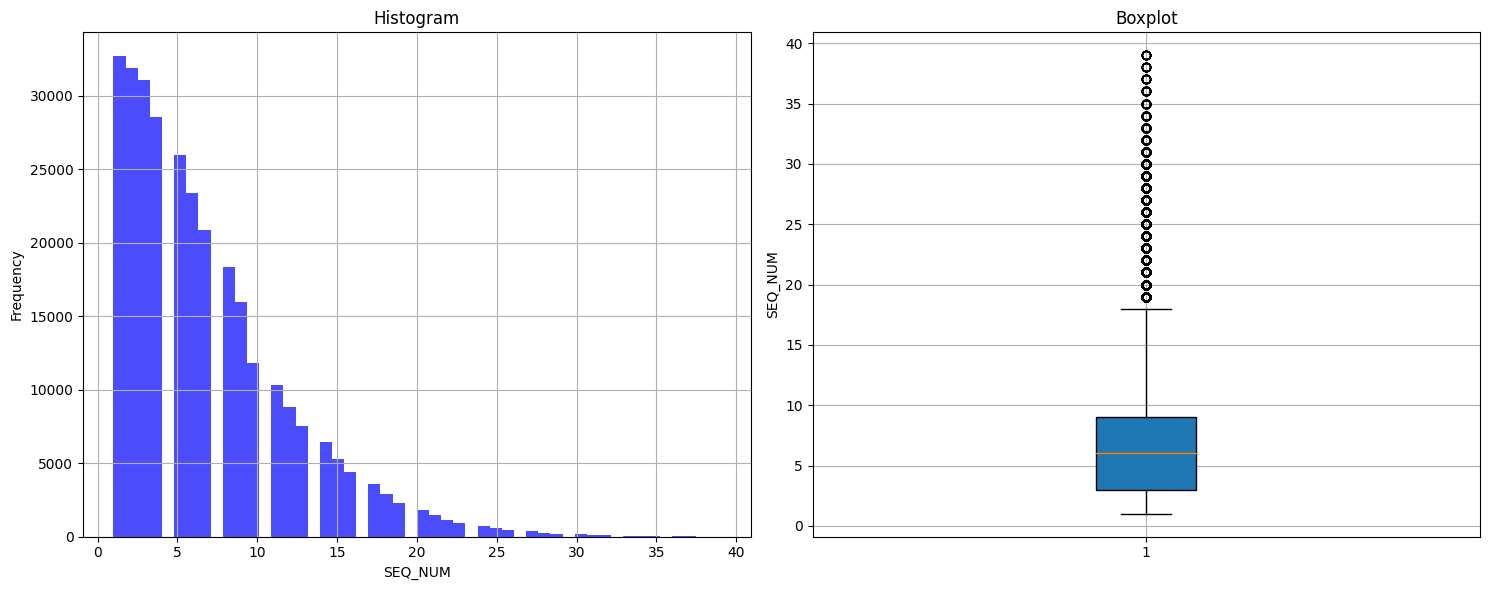

In [ ]:
plot_hist_and_boxplot(seq_num_data, "SEQ_NUM")


We can see that the number of values ​​for high priority is much greater than for the rest.

In [ ]:
aggregated_SEQ_NUM_df = joined_df.groupBy("SEQ_NUM").agg(
    F.min("LOS").alias("Min_LOS"),
    F.expr("percentile_approx(LOS, 0.25)").alias("25th_Percentile_LOS"),
    F.expr("percentile_approx(LOS, 0.50)").alias("50th_Percentile_LOS"),
    F.expr("percentile_approx(LOS, 0.75)").alias("75th_Percentile_LOS"),
    F.expr("percentile_approx(LOS, 0.9)").alias("90th_Percentile_LOS"),
    F.expr("percentile_approx(LOS, 0.9)").alias("95th_Percentile_LOS"),
    F.max("LOS").alias("Max_LOS"),
).orderBy(col("SEQ_NUM"))
aggregated_SEQ_NUM_df.show()

+-------+-------+-------------------+-------------------+-------------------+-------------------+-------------------+-------+
|SEQ_NUM|Min_LOS|25th_Percentile_LOS|50th_Percentile_LOS|75th_Percentile_LOS|90th_Percentile_LOS|95th_Percentile_LOS|Max_LOS|
+-------+-------+-------------------+-------------------+-------------------+-------------------+-------------------+-------+
|    1.0| 2.0E-4|             0.9667|             1.6987|             3.0255|             5.1924|             5.1924| 9.1373|
|    2.0| 2.0E-4|               0.97|             1.7028|             3.0258|             5.1745|             5.1745| 9.1373|
|    3.0| 3.0E-4|             0.9841|             1.7319|             3.0588|             5.2201|             5.2201| 9.1373|
|    4.0| 3.0E-4|             1.0556|             1.8475|             3.1715|             5.4375|             5.4375| 9.1373|
|    5.0| 3.0E-4|             1.1199|             1.9451|             3.3145|             5.6643|             5.6643| 

We can see that the waiting time only really starts to move away from the one with the highest priority, SEQ_NUM=1, when SEQ_NUM passes 16, which is when it increases by at least 1, seeing that the distance between SEQ_NUM nearby is low

In [ ]:
title_counts = joined_df.groupBy("SEQ_NUM", "ICD9_CODE", "LONG_TITLE").agg(count("LONG_TITLE").alias("count")).orderBy(col("count").desc())

title_counts.toPandas()

,SEQ_NUM,ICD9_CODE,LONG_TITLE,count
0,1.0,V3000,"Single liveborn, born in hospital, delivered w...",2998
1,1.0,41401,Coronary atherosclerosis of native coronary ar...,2714
2,1.0,V3001,"Single liveborn, born in hospital, delivered b...",1967
3,5.0,4019,Unspecified essential hypertension,1537
4,6.0,4019,Unspecified essential hypertension,1533
...,...,...,...,...
35502,21.0,30001,Panic disorder without agoraphobia,1
35503,2.0,5198,"Other diseases of respiratory system, not else...",1
35504,7.0,78442,Dysphonia,1
35505,6.0,80227,"Closed fracture of mandible, alveolar border o...",1


Because it was difficult to understand, what was decided was to print the first 10 rows of the table, so that we could have an idea of ​​the most common elements, given the rank.

In [ ]:
for index, row in title_counts.toPandas().iterrows():
  if index >9:
    break
  print(f"---------{index+1}---------")
  print(f"Title: {row['SEQ_NUM']}")

  print(f"Title: {row['LONG_TITLE']}")

  print(f"Title: {row['count']}")
  print(f"------------------")


---------1---------
Title: 1.0
Title: Single liveborn, born in hospital, delivered without mention of cesarean section
Title: 2998
------------------
---------2---------
Title: 1.0
Title: Coronary atherosclerosis of native coronary artery
Title: 2714
------------------
---------3---------
Title: 1.0
Title: Single liveborn, born in hospital, delivered by cesarean section
Title: 1967
------------------
---------4---------
Title: 5.0
Title: Unspecified essential hypertension
Title: 1537
------------------
---------5---------
Title: 6.0
Title: Unspecified essential hypertension
Title: 1533
------------------
---------6---------
Title: 4.0
Title: Unspecified essential hypertension
Title: 1505
------------------
---------7---------
Title: 3.0
Title: Need for prophylactic vaccination and inoculation against viral hepatitis
Title: 1423
------------------
---------8---------
Title: 7.0
Title: Unspecified essential hypertension
Title: 1317
------------------
---------9---------
Title: 2.0
Title:

We can see that given the grouping by rank, the first 10 descriptions are related to hypertension. We can also see that in first and third place we have the reason for ICU being newborn.

#### LONG_TITLE analysis

In [ ]:
long_title_counts = joined_df.groupBy("ICD9_CODE", "LONG_TITLE").agg(count("ICD9_CODE").alias("count")).orderBy(col("count").desc())

long_title_counts_pd = long_title_counts.toPandas()
long_title_counts_pd.head(10)

,ICD9_CODE,LONG_TITLE,count
0,4019,Unspecified essential hypertension,12093
1,41401,Coronary atherosclerosis of native coronary ar...,7465
2,42731,Atrial fibrillation,6217
3,4280,"Congestive heart failure, unspecified",5263
4,2724,Other and unspecified hyperlipidemia,4926
5,25000,Diabetes mellitus without mention of complicat...,4628
6,V053,Need for prophylactic vaccination and inoculat...,4365
7,V290,Observation for suspected infectious condition,4007
8,5849,"Acute kidney failure, unspecified",3838
9,2720,Pure hypercholesterolemia,3589


Once we have text data, for better visualization, what will be created is a wordcloud. The objective will be to identify key words so that we can have an idea of ​​the main issues related to ICU

In [ ]:
long_titles_text = ' '.join(long_title_counts_pd['LONG_TITLE'].astype(str)[:10])


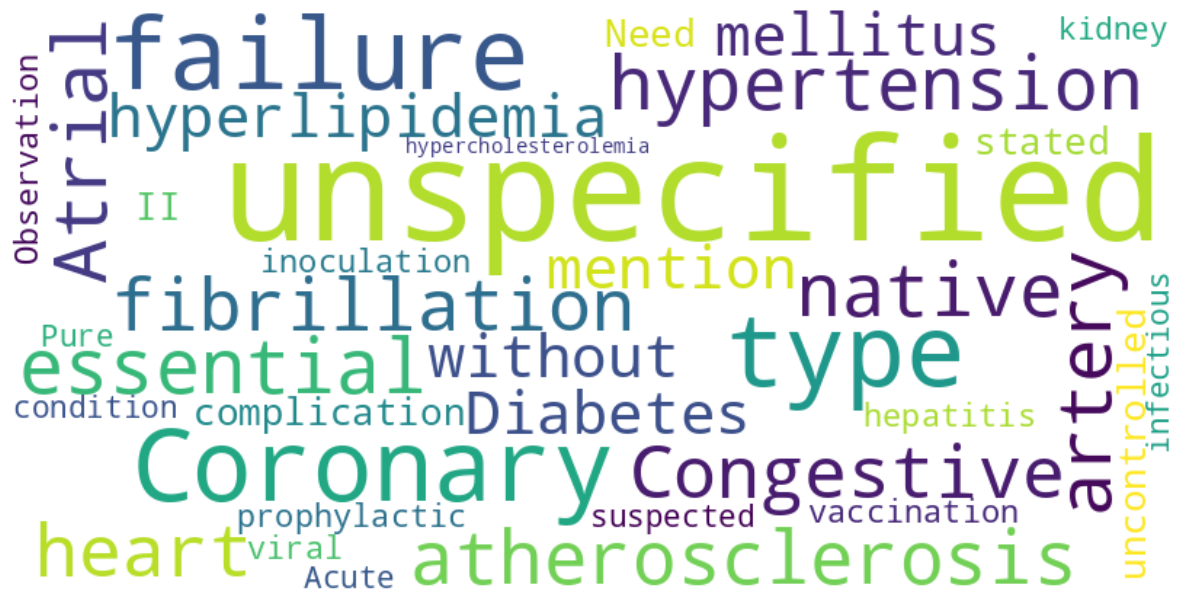

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(long_titles_text)

# Exibir a word cloud
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

If we are not going to consider the word "unspeified", we can look at key words to get an idea of ​​the main subject of the top 10. We can look at words like "hypertension" or "artery" or "coronary", that is, just words related to the heart. We can see that the top 10 topics related to ICU admission are related to heart problems.

#### Update Table

In [ ]:
tables_loaded["ICUSTAYS_x_DIAGNOSES_ICD_x_D_ICD_DIAGNOSES"] = joined_df

### All Tables

What will be done now is the preparation to join all the columns to begin the final analysis and thus the modeling.

In [ ]:
chartevents_x_ditems = tables_loaded["chartevents_x_ditems"]
Admissions_x_Patients = tables_loaded["Admissions_x_Patients"]
ICUSTAYS_x_DIAGNOSES_ICD_x_D_ICD_DIAGNOSES =  tables_loaded["ICUSTAYS_x_DIAGNOSES_ICD_x_D_ICD_DIAGNOSES"]

In [ ]:
chartevents_x_ditems = chartevents_x_ditems.drop("CHARTTIME", "STORETIME","ROW_ID")
chartevents_x_ditems.show(5)


+----------+-------+----------+------+-----+--------+--------+----------------+
|SUBJECT_ID|HADM_ID|ICUSTAY_ID|ITEMID|VALUE|VALUENUM|VALUEUOM|           LABEL|
+----------+-------+----------+------+-----+--------+--------+----------------+
|         2| 163353|  243653.0|   211|  140|   140.0|     BPM|      Heart Rate|
|         2| 163353|  243653.0|   211|  144|   144.0|     BPM|      Heart Rate|
|         2| 163353|  243653.0|   211|  131|   131.0|     BPM|      Heart Rate|
|         3| 145834|  211552.0|   646|   99|    99.0|       %|            SpO2|
|         3| 145834|  211552.0|   618|   16|    16.0|    BrPM|Respiratory Rate|
+----------+-------+----------+------+-----+--------+--------+----------------+
only showing top 5 rows



In [ ]:
Admissions_x_Patients = Admissions_x_Patients.drop("ROW_ID", "DIAGNOSIS", "ADMITTIME","DISCHTIME","DEATHTIME", "EDREGTIME","EDOUTTIME","HOSPITAL_EXPIRE_FLAG", "HAS_CHARTEVENTS_DATA", "total", "DOB", "DOD")
Admissions_x_Patients.show(5)
Admissions_x_Patients

+----------+-------+--------------+--------------------+------------------+----------+--------------+-----------+------------------+------+---+
|SUBJECT_ID|HADM_ID|ADMISSION_TYPE|  ADMISSION_LOCATION|DISCHARGE_LOCATION| INSURANCE|MARITAL_STATUS|IS_DECEASED|     STAY_DURATION|GENDER|AGE|
+----------+-------+--------------+--------------------+------------------+----------+--------------+-----------+------------------+------+---+
|      7275| 136809|     EMERGENCY|EMERGENCY ROOM ADMIT|               ICF|  Medicare|      DIVORCED|          0|             99.95|     M| 60|
|     17575| 187131|     EMERGENCY|EMERGENCY ROOM ADMIT|               ICF|Government|        SINGLE|          0|             266.7|     M| 18|
|     32339| 181355|     EMERGENCY|EMERGENCY ROOM ADMIT|               ICF|  Medicare|       MARRIED|          0|135.23333333333332|     M| 90|
|     58899| 177890|     EMERGENCY|EMERGENCY ROOM ADMIT|               ICF|  Medicare|        SINGLE|          0|             151.8|    

DataFrame[SUBJECT_ID: bigint, HADM_ID: bigint, ADMISSION_TYPE: string, ADMISSION_LOCATION: string, DISCHARGE_LOCATION: string, INSURANCE: string, MARITAL_STATUS: string, IS_DECEASED: int, STAY_DURATION: double, GENDER: string, AGE: int]

In [ ]:
ICUSTAYS_x_DIAGNOSES_ICD_x_D_ICD_DIAGNOSES = ICUSTAYS_x_DIAGNOSES_ICD_x_D_ICD_DIAGNOSES.drop("SHORT_TITLE", "LONG_TITLE", "INTIME", "OUTTIME", "ROW_ID")
ICUSTAYS_x_DIAGNOSES_ICD_x_D_ICD_DIAGNOSES.show(5)

+----------+-------+-------+---------+----------+------+
|SUBJECT_ID|HADM_ID|SEQ_NUM|ICD9_CODE|ICUSTAY_ID|   LOS|
+----------+-------+-------+---------+----------+------+
|       512| 102509|    1.0|    V3101|    299370|1.1889|
|       512| 102509|    2.0|    76519|    299370|1.1889|
|       512| 102509|    3.0|    76528|    299370|1.1889|
|       512| 102509|    4.0|     V053|    299370|1.1889|
|       768| 170167|    1.0|    56081|    216049|2.9181|
+----------+-------+-------+---------+----------+------+
only showing top 5 rows



#### Pre Processing

In [ ]:
join1 = chartevents_x_ditems.join(
    Admissions_x_Patients,
    on=["SUBJECT_ID", "HADM_ID"],
    how="inner"
)

join1.show(5)

+----------+-------+----------+------+-----------+--------+--------+----------------+--------------+--------------------+------------------+---------+--------------+-----------+-----------------+------+---+
|SUBJECT_ID|HADM_ID|ICUSTAY_ID|ITEMID|      VALUE|VALUENUM|VALUEUOM|           LABEL|ADMISSION_TYPE|  ADMISSION_LOCATION|DISCHARGE_LOCATION|INSURANCE|MARITAL_STATUS|IS_DECEASED|    STAY_DURATION|GENDER|AGE|
+----------+-------+----------+------+-----------+--------+--------+----------------+--------------+--------------------+------------------+---------+--------------+-----------+-----------------+------+---+
|      1580| 111714|  215843.0|   550|  Universal|    NULL|    NULL|     Precautions|     EMERGENCY|EMERGENCY ROOM ADMIT|              HOME| Medicaid|      DIVORCED|          0|282.6166666666667|     F| 44|
|      1580| 111714|  215843.0|   212|Sinus Tachy|    NULL|    NULL|    Heart Rhythm|     EMERGENCY|EMERGENCY ROOM ADMIT|              HOME| Medicaid|      DIVORCED|       

In [ ]:
final_df = join1.join(
    ICUSTAYS_x_DIAGNOSES_ICD_x_D_ICD_DIAGNOSES,
    on=["SUBJECT_ID", "HADM_ID", "ICUSTAY_ID"],
    how="inner"
)

final_df.show(5)

+----------+-------+----------+------+-----+--------+--------+------------+--------------+--------------------+--------------------+---------+--------------+-----------+------------------+------+---+-------+---------+------+
|SUBJECT_ID|HADM_ID|ICUSTAY_ID|ITEMID|VALUE|VALUENUM|VALUEUOM|       LABEL|ADMISSION_TYPE|  ADMISSION_LOCATION|  DISCHARGE_LOCATION|INSURANCE|MARITAL_STATUS|IS_DECEASED|     STAY_DURATION|GENDER|AGE|SEQ_NUM|ICD9_CODE|   LOS|
+----------+-------+----------+------+-----+--------+--------+------------+--------------+--------------------+--------------------+---------+--------------+-----------+------------------+------+---+-------+---------+------+
|         4| 185777|  294638.0|  1125|MSICU|    NULL|    NULL|Service Type|     EMERGENCY|EMERGENCY ROOM ADMIT|HOME WITH HOME IV...|  Private|        SINGLE|          0|186.21666666666667|     F| 47|    1.0|      042|1.6785|
|         4| 185777|  294638.0|  1125|MSICU|    NULL|    NULL|Service Type|     EMERGENCY|EMERGENCY 

In [ ]:
final_df = final_df.drop("SUBJECT_ID", "HADM_ID", "ICUSTAY_ID", "ITEMID", "ICD9_CODE")


In [ ]:
final_df.show(5)

+-----+--------+--------+-----+--------------+--------------------+--------------------+---------+--------------+-----------+------------------+------+---+-------+------+
|VALUE|VALUENUM|VALUEUOM|LABEL|ADMISSION_TYPE|  ADMISSION_LOCATION|  DISCHARGE_LOCATION|INSURANCE|MARITAL_STATUS|IS_DECEASED|     STAY_DURATION|GENDER|AGE|SEQ_NUM|   LOS|
+-----+--------+--------+-----+--------------+--------------------+--------------------+---------+--------------+-----------+------------------+------+---+-------+------+
|  100|   100.0|       %| SpO2|     EMERGENCY|EMERGENCY ROOM ADMIT|HOME WITH HOME IV...|  Private|        SINGLE|          0|186.21666666666667|     F| 47|    1.0|1.6785|
|  100|   100.0|       %| SpO2|     EMERGENCY|EMERGENCY ROOM ADMIT|HOME WITH HOME IV...|  Private|        SINGLE|          0|186.21666666666667|     F| 47|    2.0|1.6785|
|  100|   100.0|       %| SpO2|     EMERGENCY|EMERGENCY ROOM ADMIT|HOME WITH HOME IV...|  Private|        SINGLE|          0|186.21666666666667| 

In [ ]:
tables_loaded["final_table"] = final_df

# Modeling

In [ ]:
final_table = tables_loaded["final_table"]

In [ ]:
final_table.count()

15064302

## Pre Processing

In [ ]:
categoricalColumns = ['ADMISSION_TYPE', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'INSURANCE', 'MARITAL_STATUS', 'GENDER', 'LABEL']
indexers = [
    StringIndexer(inputCol=column, outputCol=column + "_index", handleInvalid="skip")
    for column in categoricalColumns
]

In [ ]:
encoders = [
    OneHotEncoder(inputCols=[indexer.getOutputCol()], outputCols=[indexer.getOutputCol().replace("_index", "_vec")])
    for indexer in indexers
]

In [ ]:
assemblerInputs = [encoder.getOutputCols()[0] for encoder in encoders] + ['AGE', 'SEQ_NUM', 'STAY_DURATION']
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

In [ ]:
pipeline = Pipeline(stages=indexers + encoders + [assembler])
model = pipeline.fit(final_table)
transformed_df = model.transform(final_table)

In [ ]:

lr = LinearRegression(featuresCol='features', labelCol='LOS')


In [ ]:
transformed_df = transformed_df.dropna()

In [ ]:
train_data, test_data = transformed_df.randomSplit([0.8, 0.2], seed=42)


In [ ]:
lr_model = lr.fit(train_data)

Py4JJavaError: An error occurred while calling o3125.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 1370.0 failed 1 times, most recent failure: Lost task 1.0 in stage 1370.0 (TID 1043) (6599696fb16e executor driver): java.lang.OutOfMemoryError: Java heap space
	at org.apache.spark.util.collection.unsafe.sort.UnsafeSorterSpillReader.<init>(UnsafeSorterSpillReader.java:50)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeSorterSpillWriter.getReader(UnsafeSorterSpillWriter.java:159)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.getSortedIterator(UnsafeExternalSorter.java:555)
	at org.apache.spark.sql.execution.UnsafeExternalRowSorter.sort(UnsafeExternalRowSorter.java:172)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage21.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$4(RDD.scala:1264)
	at org.apache.spark.rdd.RDD$$Lambda$4924/0x0000000841c35840.apply(Unknown Source)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$6(RDD.scala:1265)
	at org.apache.spark.rdd.RDD$$Lambda$4925/0x0000000841c37040.apply(Unknown Source)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:858)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:858)
	at org.apache.spark.rdd.RDD$$Lambda$4076/0x000000084196c040.apply(Unknown Source)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2493)
	at org.apache.spark.rdd.RDD.$anonfun$fold$1(RDD.scala:1202)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.fold(RDD.scala:1196)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$2(RDD.scala:1289)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1256)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$1(RDD.scala:1242)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:410)
	at org.apache.spark.rdd.RDD.treeAggregate(RDD.scala:1242)
	at org.apache.spark.mllib.stat.Statistics$.colStats(Statistics.scala:58)
	at org.apache.spark.mllib.evaluation.RegressionMetrics.summary$lzycompute(RegressionMetrics.scala:70)
	at org.apache.spark.mllib.evaluation.RegressionMetrics.summary(RegressionMetrics.scala:62)
	at org.apache.spark.mllib.evaluation.RegressionMetrics.SSreg$lzycompute(RegressionMetrics.scala:76)
	at org.apache.spark.mllib.evaluation.RegressionMetrics.SSreg(RegressionMetrics.scala:77)
	at org.apache.spark.mllib.evaluation.RegressionMetrics.explainedVariance(RegressionMetrics.scala:88)
	at org.apache.spark.ml.regression.LinearRegressionSummary.<init>(LinearRegression.scala:934)
	at org.apache.spark.ml.regression.LinearRegressionTrainingSummary.<init>(LinearRegression.scala:877)
	at org.apache.spark.ml.regression.LinearRegression.trainWithNormal(LinearRegression.scala:463)
	at org.apache.spark.ml.regression.LinearRegression.$anonfun$train$1(LinearRegression.scala:354)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.regression.LinearRegression.train(LinearRegression.scala:329)
	at org.apache.spark.ml.regression.LinearRegression.train(LinearRegression.scala:186)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:114)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.lang.OutOfMemoryError: Java heap space
	at org.apache.spark.util.collection.unsafe.sort.UnsafeSorterSpillReader.<init>(UnsafeSorterSpillReader.java:50)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeSorterSpillWriter.getReader(UnsafeSorterSpillWriter.java:159)
	at org.apache.spark.util.collection.unsafe.sort.UnsafeExternalSorter.getSortedIterator(UnsafeExternalSorter.java:555)
	at org.apache.spark.sql.execution.UnsafeExternalRowSorter.sort(UnsafeExternalRowSorter.java:172)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage21.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$4(RDD.scala:1264)
	at org.apache.spark.rdd.RDD$$Lambda$4924/0x0000000841c35840.apply(Unknown Source)
	at org.apache.spark.rdd.RDD.$anonfun$treeAggregate$6(RDD.scala:1265)
	at org.apache.spark.rdd.RDD$$Lambda$4925/0x0000000841c37040.apply(Unknown Source)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2(RDD.scala:858)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitions$2$adapted(RDD.scala:858)
	at org.apache.spark.rdd.RDD$$Lambda$4076/0x000000084196c040.apply(Unknown Source)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
